# Аналитика в Яндекс.Афише

## Описание проекта

Данный проект имитирует стажировку в отделе аналитики Яндекс.Афиши. Мне дано техническое задание: помочь маркетологам оптимизировать маркетинговые затраты.

В распоряжении есть данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:
- лог сервера с данными о посещениях сайта Яндекс.Афиши,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов.

В процессе работы над проектом будут даны ответы на следующие вопросы:
- как люди пользуются продуктом,
- когда они начинают покупать,
- сколько денег приносит каждый клиент
- когда клиент окупается.

Проект будет состоять из следующих шагов:

### Шаг 1. Загрузка данных и подготовка их к анализу
Загрузка данных о визитах, заказах и расходах в переменные. Оптимизация данных и их проверка для дальнейшей работы.

### Шаг 2. Построение отчётов и расчет метрик
Отчеты, графики и обоснование для следующих метрик:

**Продукт**
- Сколько людей пользуются в день, неделю, месяц?
- Сколько сессий в день?
- Сколько длится одна сессия?
- Как часто люди возвращаются?

**Продажи**
- Когда люди начинают покупать?
- Сколько раз покупают за период?
- Какой средний чек?
- Сколько денег приносят? (LTV)

**Маркетинг**
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько стоило привлечение одного покупателя из каждого источника?
- На сколько окупились расходы? (ROI)

### Шаг 3. Вывод: рекомендации маркетологам, куда и сколько им стоит вкладывать денег.
Общие выводы по итогам исследуемых метрик. Рекомендации для выбора источников/платформ для вложения денег.

## Описание данных

Таблица **_visits_** (лог сервера с информацией о посещениях сайта):
- _Uid_ — уникальный идентификатор пользователя
- _Device_ — категория устройства пользователя
- _Start Ts_ — дата и время начала сессии
- _End Ts_ — дата и время окончания сессии
- _Source Id_ — идентификатор рекламного источника, из которого пришел пользователь.

Таблица **_orders_** (информация о заказах):
- _Uid_ — уникальный id пользователя, который сделал заказ
- _Buy Ts_ — дата и время заказа
- _Revenue_ — выручка Яндекс.Афиши с этого заказа.

Таблица **_costs_** (информация о затратах на маркетинг):
- _source_id_ — идентификатор рекламного источника
- _dt_ — дата
- _costs_ — затраты на этот рекламный источник в этот день.

## Шаг 1. Загрузка данных и подготовка их к анализу

Загрузим исходные три датафрейма

In [148]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Сохранение датафреймов в переменные
visits = pd.read_csv('C:\Datasets/visits_log.csv')
orders = pd.read_csv('C:\Datasets/orders_log.csv')
costs = pd.read_csv('C:\Datasets/costs.csv')

Рассмотрим каждый датафрейм по отдельности. Узнаем, что внутри и всю общую информацию.

Первым на очереди идет лог сервера с информацией о посещениях сайта.

In [149]:
# Просмотрим общую информацию
visits.info()
# Числовые характеристики
print(visits.describe())
# Вывод 10 первых строк
visits.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB
           Source Id           Uid
count  359400.000000  3.594000e+05
mean        3.750515  9.202557e+18
std         1.917116  5.298433e+18
min         1.000000  1.186350e+13
25%         3.000000  4.613407e+18
50%         4.000000  9.227413e+18
75%         5.000000  1.372824e+19
max        10.000000  1.844668e+19


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063


Из info() сразу видим, что столбцы со временем начала и конца сессии имеют неверный тип данных. Исправим это. 

Впервые столкнулся  типом данных uint. Думал, что это тоше ошибка, но после прочтения информации в интернете стало ясно, почему тут выбран этот тип данных.

Также непривычно видеть весьма странные названия столбцов. Переведу в нижний регистр и избавлюсь от пробелов.

In [150]:
# Смена наименований столбцов
visits.columns = visits.columns.str.lower().str.replace(' ', '_')

In [151]:
# Смена типа данных в столбцах с датами
visits['end_ts'] = pd.to_datetime(visits['end_ts'])
visits['start_ts'] = pd.to_datetime(visits['start_ts'])
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   device     359400 non-null  object        
 1   end_ts     359400 non-null  datetime64[ns]
 2   source_id  359400 non-null  int64         
 3   start_ts   359400 non-null  datetime64[ns]
 4   uid        359400 non-null  uint64        
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


Далее нам понадобятся значения длительности сессии. Давайте посчитаем

In [152]:
visits['duration_ts'] = (visits['end_ts'] - visits['start_ts']) / np.timedelta64(1, 's')
visits['duration_ts'] = visits['duration_ts'].astype('int')

In [153]:
# Проверю наличие багов в данных
visits[visits['duration_ts'] < 0]

,device,end_ts,source_id,start_ts,uid,duration_ts
4181,desktop,2018-03-25 03:18:00,3,2018-03-25 03:50:00,13092152539246794986,-1920
177972,desktop,2018-03-25 03:09:00,9,2018-03-25 03:55:00,4621202742905035453,-2760


In [154]:
# Избавлюсь от 2 сессий с отрицательной длительностью
visits = visits[visits['duration_ts'] >= 0]

Узнаю, какой период охватывают данные

In [155]:
print('Начало:',visits['start_ts'].min())
print('Конец:',visits['start_ts'].max())

Начало: 2017-06-01 00:01:00
Конец: 2018-05-31 23:59:00


Ровно год. Сразу можно сказать, что у нас получится 12 полноценных когорт.

Теперь посмотрим, как обстоят дела с таблицей с информацией о заказах

In [156]:
# Аналогично с прошлой таблицей
orders.info()
print(orders.describe())
orders.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB
            Revenue           Uid
count  50415.000000  5.041500e+04
mean       4.999647  9.098161e+18
std       21.818359  5.285742e+18
min        0.000000  3.135781e+14
25%        1.220000  4.533567e+18
50%        2.500000  9.102274e+18
75%        4.890000  1.368290e+19
max     2633.280000  1.844617e+19


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
5,2017-06-01 08:43:00,0.18,10402394430196413321
6,2017-06-01 08:54:00,1.83,12464626743129688638
7,2017-06-01 09:22:00,1.22,3644482766749211722
8,2017-06-01 09:22:00,3.30,17542070709969841479
9,2017-06-01 09:23:00,0.37,1074355127080856382


Те же проблемы, что и в прошлый раз. Также видно, что есть строки с нулевой выручкой. 

Починим!

In [157]:
# Приведение столбцов к угодному мне виду
orders.columns = orders.columns.str.lower().str.replace(' ', '_')

In [158]:
# Перевод тип данных
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])
# Проверим изменения
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   buy_ts   50415 non-null  datetime64[ns]
 1   revenue  50415 non-null  float64       
 2   uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


In [159]:
# Посмотрим на количество случаев нулевой выручки
orders[orders['revenue'] == 0].count()

buy_ts     51
revenue    51
uid        51
dtype: int64

Их сравнительно мало. Это скорее всего баг оплаты, либо её отмена или что-то из этого. Эти строки можно без страха удалять.

In [160]:
orders = orders[orders['revenue'] != 0]
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50364 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   buy_ts   50364 non-null  datetime64[ns]
 1   revenue  50364 non-null  float64       
 2   uid      50364 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.5 MB


Все исправлено. 

Разберемся с последним датасетом с информацией о затратах на маркетинг

In [161]:
# Вся общая информация
costs.info()
print(costs.describe())
costs.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB
         source_id        costs
count  2542.000000  2542.000000
mean      4.857199   129.477427
std       3.181581   156.296628
min       1.000000     0.540000
25%       2.000000    21.945000
50%       4.000000    77.295000
75%       9.000000   170.065000
max      10.000000  1788.280000


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
5,1,2017-06-06,40.39
6,1,2017-06-07,40.59
7,1,2017-06-08,56.63
8,1,2017-06-09,40.16
9,1,2017-06-10,43.24


Названия столбцов в порядке, никаких странных значений в столбцах, но опять что-то с датами.

In [162]:
costs['dt'] = pd.to_datetime(costs['dt'])
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   int64         
 1   dt         2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


С исправлениями типов данных покончено.

### Вывод 

Были загружены три датасета с информацией о посещениях сайта, заказах и затратах на маркетинг. 

Серьезных проблем с данными не возникло. Лишь не понятная проблема с датами пришедшая ещё с тренажера. Были исправлены типы данных, убраны строки с  подозрительными значениями, названия столбцов приведены к нормальному виду.

Сразу бросается в глаза связь этих таблиц. **_users_** связана с **_orders_** и **_costs_** данными из столбцов _uid_ и _sours_id_ соответственно.

## Шаг 2. Построение отчётов и расчет метрик

На данном шаге я буду считать поведенческие и финансовые метрики. Отображу ихх на графиках, покажу как они различаются по устройствам и рекламным источникам, как они меняются по времени.

Начну с **пользовательских метрик**. Они помогут нам ответить на данные в введении вопросы.

### Оценка пользовательской активности

Узнаем, сколько людей пользуются сайтом в день, неделю, месяц. 

На активных пользователей смотрят в трёх измерениях:
- **DAU** (от англ. daily active users) — количество уникальных пользователей в день;
- **WAU** (от англ. weekly active users) — количество уникальных пользователей в неделю;
- **MAU** (от англ. monthly active users) — количество уникальных пользователей в месяц.

Чтобы посчитать дневное, недельное и месячное использование, выделим в отдельные столбцы дату, неделю и месяц.

In [163]:
# Выделение дней
visits['session_date'] = visits['start_ts'].dt.date
# Выделение недель
visits['session_week'] = visits['start_ts'].astype('datetime64[W]')
# Выделение месяцев
visits['session_month'] = visits['start_ts'].astype('datetime64[M]')
# Проверим корректность
visits.head()

,device,end_ts,source_id,start_ts,uid,duration_ts,session_date,session_week,session_month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,1080,2017-12-20,2017-12-14,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,1680,2018-02-19,2018-02-15,2018-02-01
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,0,2017-07-01,2017-06-29,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,1440,2018-05-20,2018-05-17,2018-05-01
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,0,2017-12-27,2017-12-21,2017-12-01


Теперь посчитаем измерения

За данный период каждый день в среднем сайтом пользовалось 908 человек


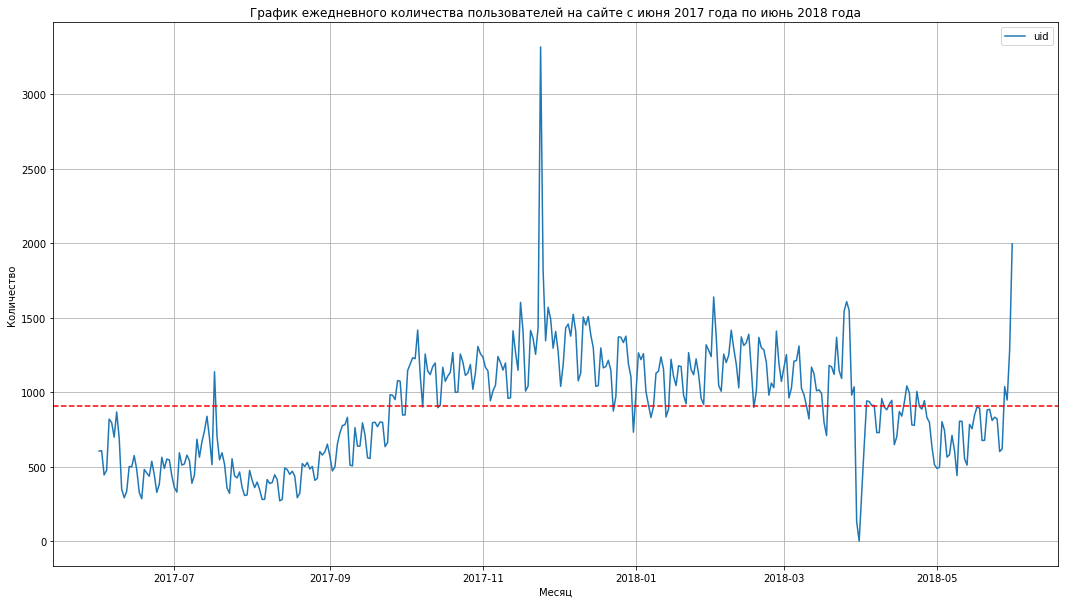

In [164]:
# Сгруппируем уникальных пользователей по дням
dau = visits.groupby('session_date').agg({'uid': 'nunique'})
# Посчитаем среднее количесвто за весь период
dau_total = dau.mean()
# Построим график распределения количества пользователей по дням
dau.plot(figsize = (18,10), grid = True)
plt.title('График ежедневного количества пользователей на сайте с июня 2017 года по июнь 2018 года')
# Покажу на графике среднее за весь период
plt.axhline(y = dau_total['uid'].round().astype('int'), linestyle='--', color = 'red')
plt.xlabel('Месяц')
plt.ylabel('Количество');
print('За данный период каждый день в среднем сайтом пользовалось {} человек'.format(dau_total['uid'].round().astype('int')))

Теперь посмотрим на еженедельное количество пользователей

За данный период каждую неделю в среднем сайтом пользовалось 5724 человека


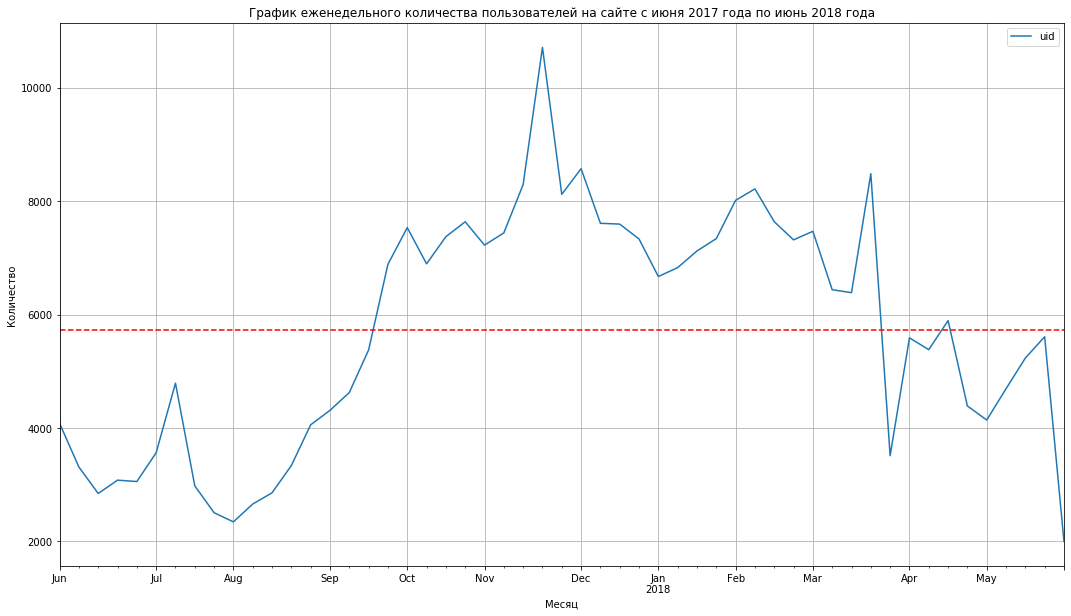

In [165]:
# Сгруппируем уникальных пользователей по неделям
wau = visits.groupby('session_week').agg({'uid': 'nunique'})
wau_total = wau.mean()

wau.plot(figsize = (18,10), grid = True)

plt.title('График еженедельного количества пользователей на сайте с июня 2017 года по июнь 2018 года')
plt.axhline(y = wau_total['uid'].round().astype('int'), linestyle='--', color = 'red')
plt.xlabel('Месяц')
plt.ylabel('Количество');
print('За данный период каждую неделю в среднем сайтом пользовалось {} человека'.format(wau_total['uid'].round().astype('int')))

Осталось распределение по месяцам

За данный период каждый месяц в среднем сайтом пользовалось 23228 человек


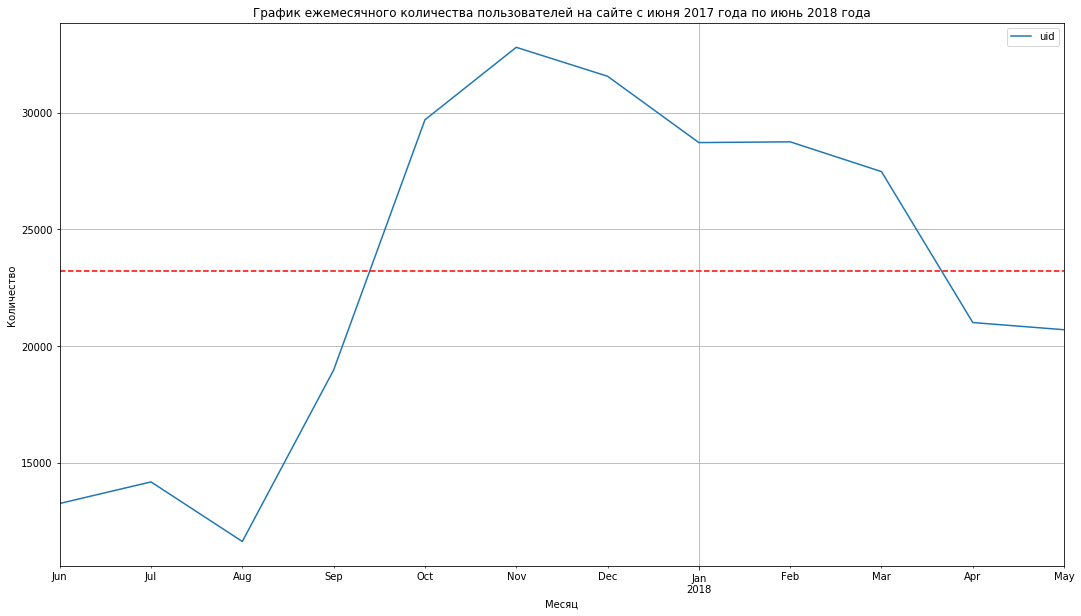

In [166]:
# Сгруппируем уникальных пользователей по месяцам
mau = visits.groupby('session_month').agg({'uid': 'nunique'})
mau_total = mau.mean()

mau.plot(figsize = (18,10), grid = True)

plt.title('График ежемесячного количества пользователей на сайте с июня 2017 года по июнь 2018 года')
plt.axhline(y = mau_total['uid'].round().astype('int'), linestyle='--', color = 'red')
plt.xlabel('Месяц')
plt.ylabel('Количество');
print('За данный период каждый месяц в среднем сайтом пользовалось {} человек'.format(mau_total['uid'].round().astype('int')))

Посмотрим, как эти метрики будут выглядеть, если мы их разделим по утсройствам. 

Построю эти графики через цикл, поэтому они будут выглядеть менее презентабельно, чем прошлые три

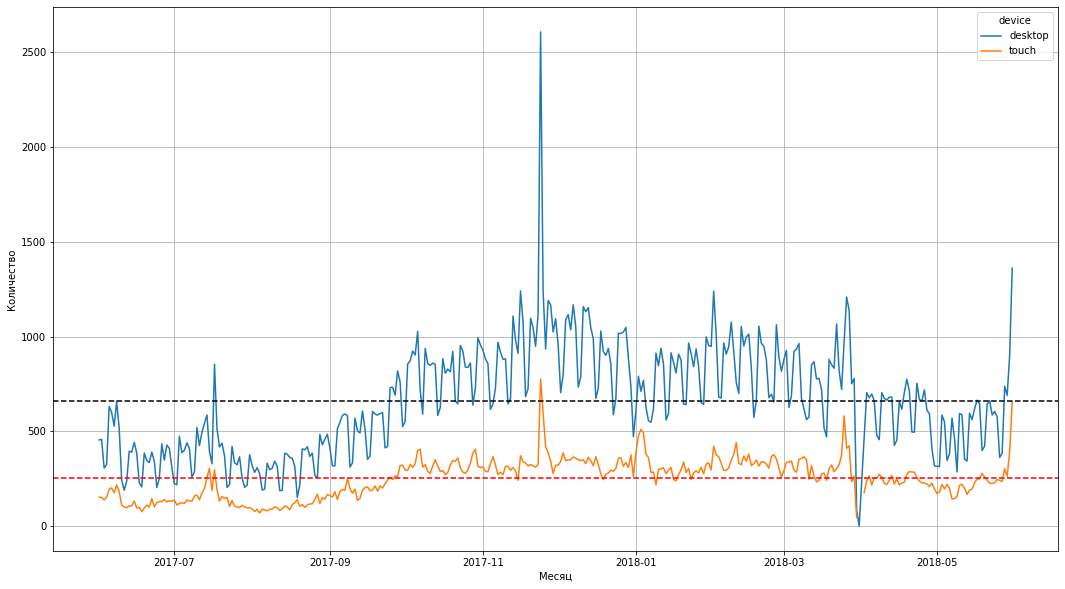

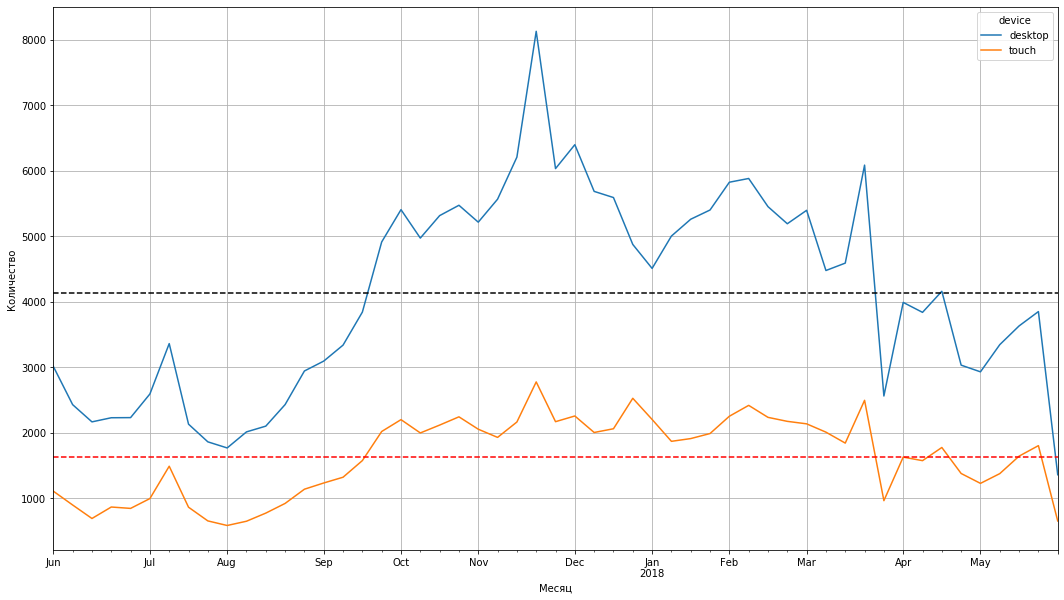

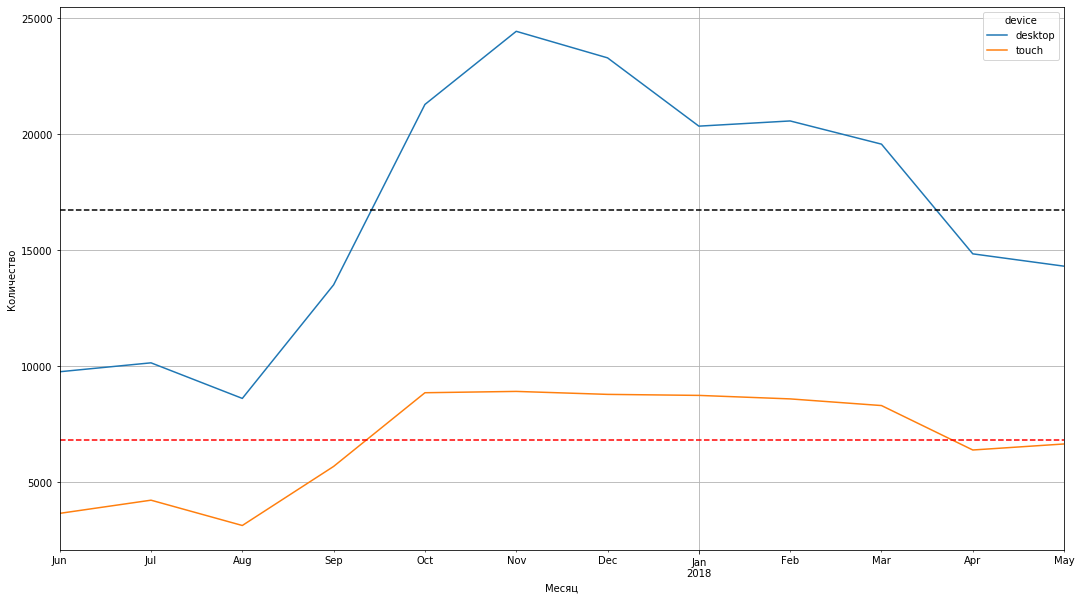

In [167]:
for date in ['session_date', 'session_week', 'session_month']:
 
    graph = visits.pivot_table(index = date, values = 'uid', columns = 'device',
                  aggfunc = 'nunique')
   
    graph.plot(figsize = (18,10), grid = True)
    plt.xlabel('Месяц')
    plt.ylabel('Количество')
    plt.axhline(y=graph['desktop'].mean(), color='black', linestyle='--')
    plt.axhline(y=graph['touch'].mean(), color='red', linestyle='--')
   
    plt.show()

Данные графики отлично показывают сколько в седнем людей пользуются сайтом в тот или иной отрезок года. 

Можно сделать **2 основных вывода**:

**_Вывод 1: Количество посещений значительно выше в период с октября по март. Пик приходится перед Новым годом_**

Это можно объяснить несколькими причинами:
1. В данный период большое количество праздников. Значит у людей больше выходных, следовательно, они чаще ходят в кино и заходят на сайт за информацией по фильмам.
2. В теплое время года люди охотнее проводят время на улице и реже ходят в кино.

**_Вывод 2: Количество посещений с ПК значительно превышает количество посещений с телефона_**

Здесь у меня всего 2 догадки:
1. Людям проще смотреть информацию с ПК, чем с телефона.
2. Посещениями с телефона неполные. Возможно, учитывались лишь те данные, которые были получены с сайта с мобильного браузера. А, допустим, посещения с приложения Афишы фиксируются в другом датасете. И эта часть где-то в другом месте.

### Пользовательская сессия

Сейчас узнаем, сколько сессий в день проходит на сайте и сколько они длятся.

Начнем с **количества сессий в день**

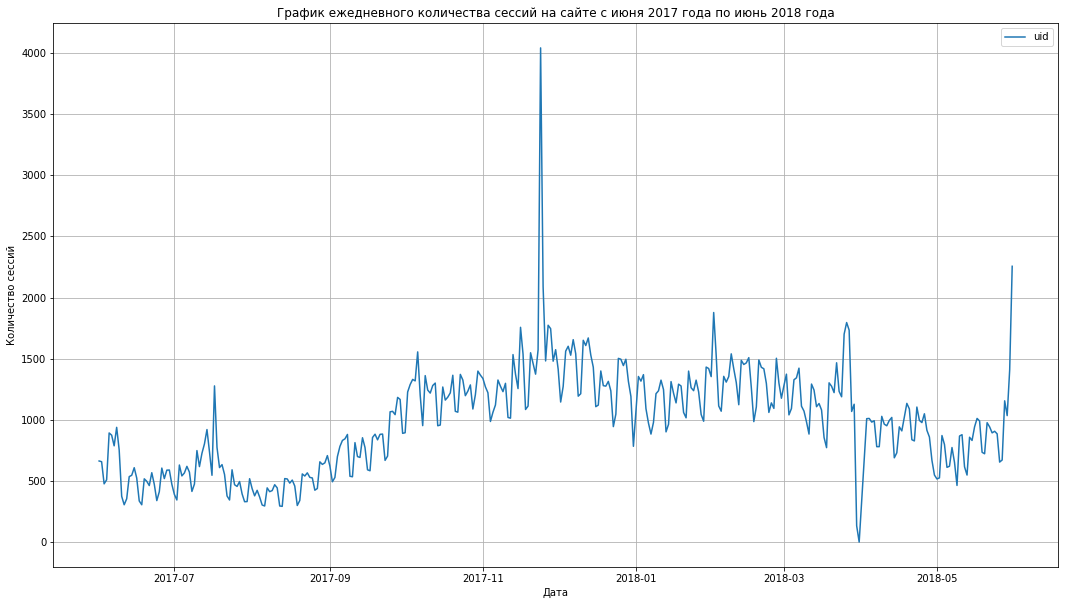

За данный период среднее количество сеансов в день равно: 987.36


,uid
session_date,
2017-06-01,664
2017-06-02,658
2017-06-03,477
2017-06-04,510
2017-06-05,893
...,...
2018-05-27,672
2018-05-28,1156
2018-05-29,1035


In [168]:
sessions_per_user = visits.groupby('session_date').agg({'uid':'count'})
sessions_per_user.plot(figsize = (18,10), grid = True)
plt.title('График ежедневного количества сессий на сайте с июня 2017 года по июнь 2018 года')
plt.xlabel('Дата')
plt.ylabel('Количество сеcсий');
plt.show()
print('За данный период среднее количество сеансов в день равно: {:.2f}'.format(sessions_per_user['uid'].mean()))
#print('Типичное количество сеансов(мода):',sessions_per_user['uid'].mode())
sessions_per_user

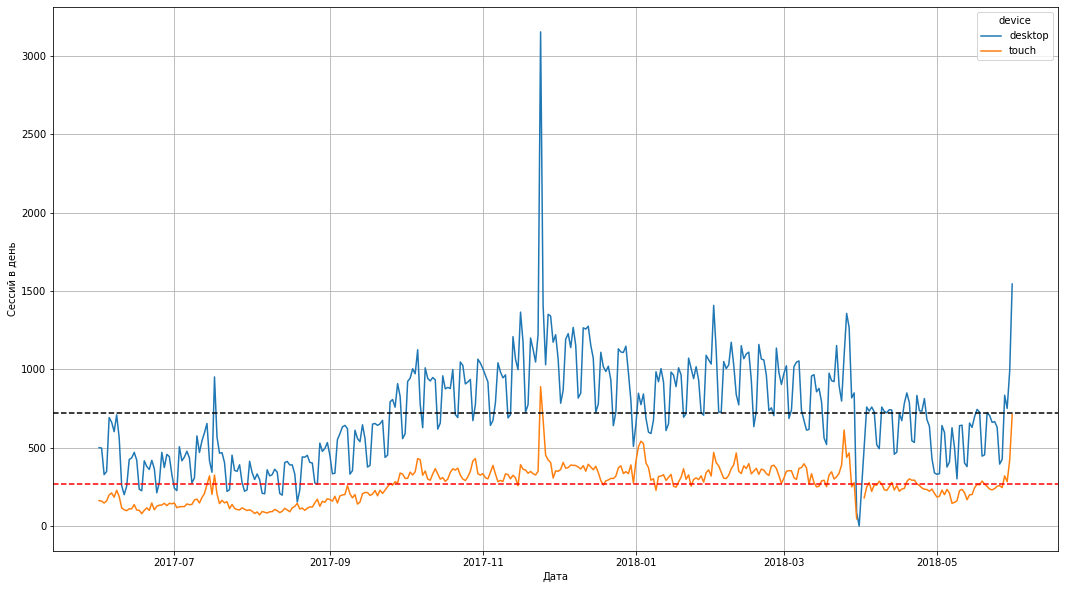

In [169]:
# Разделим по устройствам
sessions = visits.pivot_table(index = visits['session_date'], values = 'uid', columns = 'device',
                  aggfunc = 'count')
sessions.plot(figsize = (18,10), grid = True)
plt.xlabel('Дата')
plt.ylabel('Сессий в день')
plt.axhline(y=sessions['desktop'].mean(), color='black', linestyle='--')
plt.axhline(y=sessions['touch'].mean(), color='red', linestyle='--')
   
plt.show()

Данные графики идентичны графикам ежедневного количества уникальных пользователей из прошлого пункта. Поэтому выводы будут такими же.

Отличие только  в том, что значения слегка выше. Это можно объяснить тем, что каждый пользователь в большинстве случаев запускает лишь одну сессию. Та малая часть людей, которой требуется 2 или больше сессий как раз и подтягивает эти графики вверх относительно графиков ежедневного количества уникальных пользователей.

Далее узнаем **длительность сессий**. Столбец был посчитан ранее, поэтому можем сразу приступать к расчету

In [170]:
# Посмотрим на значения
visits

,device,end_ts,source_id,start_ts,uid,duration_ts,session_date,session_week,session_month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,1080,2017-12-20,2017-12-14,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,1680,2018-02-19,2018-02-15,2018-02-01
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,0,2017-07-01,2017-06-29,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,1440,2018-05-20,2018-05-17,2018-05-01
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,0,2017-12-27,2017-12-21,2017-12-01
...,...,...,...,...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539,19,2017-07-29,2017-07-27,2017-07-01
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586,19,2018-01-25,2018-01-25,2018-01-01
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294,19,2018-03-03,2018-03-01,2018-03-01
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485,19,2017-11-02,2017-11-02,2017-11-01


Cразу видны нулевые значения. Скорее всего, пользователь лишь раз зашёл на сайт, посмотрел на главную страницу, полистал и закрыл. Так как кликов внутри сайта обнаружено не было, то алгоритм поставил время окончания равным времени начала сессии.

Создадим срез, в котором уберем все сессии с нулевой длительностью

In [171]:
filtred_sessions = visits[visits['duration_ts'] != 0]
filtred_sessions = filtred_sessions.reset_index(drop=True)
filtred_sessions

,device,end_ts,source_id,start_ts,uid,duration_ts,session_date,session_week,session_month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,1080,2017-12-20,2017-12-14,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,1680,2018-02-19,2018-02-15,2018-02-01
2,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,1440,2018-05-20,2018-05-17,2018-05-01
3,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,60,2017-09-03,2017-08-31,2017-09-01
4,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451,3360,2018-01-30,2018-01-25,2018-01-01
...,...,...,...,...,...,...,...,...,...
323599,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539,19,2017-07-29,2017-07-27,2017-07-01
323600,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586,19,2018-01-25,2018-01-25,2018-01-01
323601,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294,19,2018-03-03,2018-03-01,2018-03-01
323602,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485,19,2017-11-02,2017-11-02,2017-11-01


Срез меньше оригинала примерно на 10%. Хорошо, данные чисты, теперь мы можем узнать реальную длительность сессий пользователей

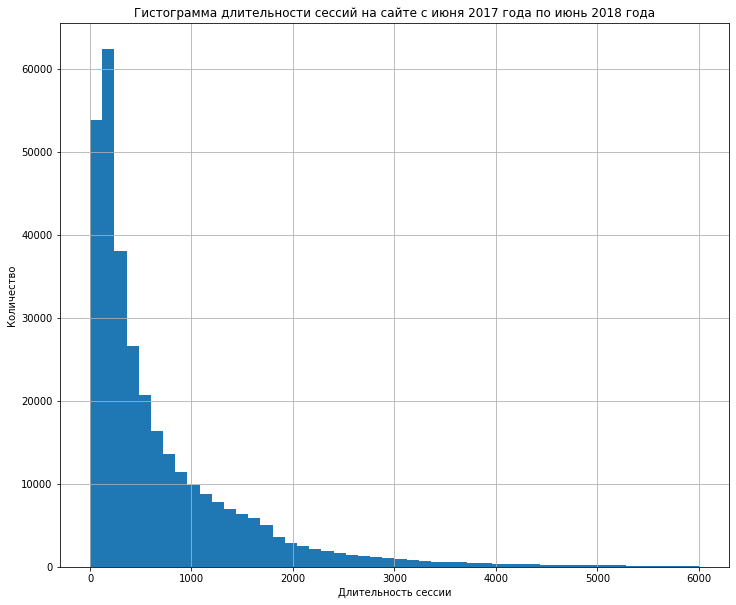

In [172]:
# Посмотрим на распределение
filtred_sessions['duration_ts'].hist(bins = 50, range = (0,6000), figsize = (12,10));
plt.title('Гистограмма длительности сессий на сайте с июня 2017 года по июнь 2018 года')
plt.xlabel('Длительность сессии')
plt.ylabel('Количество');

Длина сесиий распределена неравномерно. Нельзя считать среднюю длительность сессии простым средним арифметическим. В данном случае больше скажет типичное значение длительности сессии (мода):

In [173]:
print('Самая частая продолжительность сессии составляет {} секунд.'.format(filtred_sessions['duration_ts'].mode()[0]))

Самая частая продолжительность сессии составляет 60 секунд.


Самая частовстречаемая продолжительность сессии на ПК составляет 60 секунд.
Самая частовстречаемая продолжительность сессии на мобильных устройствах составляет 60 секунд.


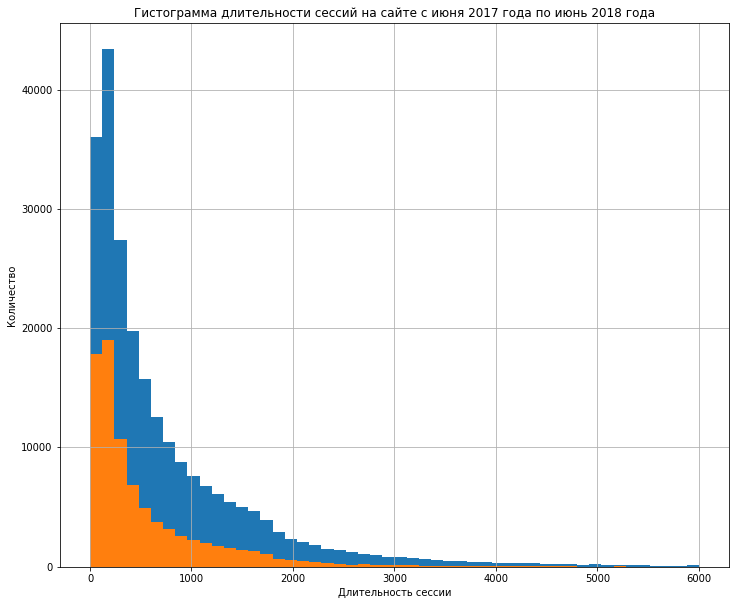

In [174]:
# Разделим по устройствам
desktop_sessions = filtred_sessions[filtred_sessions['device'] == 'desktop']
desktop_sessions['duration_ts'].hist(bins = 50, range = (0,6000), figsize = (12,10));
touch_sessions = filtred_sessions[filtred_sessions['device'] == 'touch']
touch_sessions['duration_ts'].hist(bins = 50, range = (0,6000), figsize = (12,10));
plt.title('Гистограмма длительности сессий на сайте с июня 2017 года по июнь 2018 года')
plt.xlabel('Длительность сессии')
plt.ylabel('Количество');
print('Самая частовстречаемая продолжительность сессии на ПК составляет {} секунд.'
      .format(desktop_sessions['duration_ts'].mode()[0]))
print('Самая частовстречаемая продолжительность сессии на мобильных устройствах составляет {} секунд.'
      .format(touch_sessions['duration_ts'].mode()[0]))

Была найдена самая частая продолжительность сессии - 1 минута. Она одинакова для пользователей и ПК, и мобильных утсройств.

### Retention Rate

Retention Rate показывает, сколько пользователей из когорты относительно их изначального числа вернулось в последующие периоды. Чтобы посчитать данный показатель, сначала требуется разделить пользователей на **когорты**. Наш период составляет ровно год, так что мы разделим по месяцам и на выходе получим 12 когорт.

In [175]:
# Найдем месяц первого появления пользователя на сайте
first_session_month = visits.groupby('uid')['session_month'].min()
# Смена имени объекта для избежания проблем с объединением таблиц
first_session_month.name = 'first_session_month'
# Объединим датафреймы
visits = visits.join(first_session_month, on = 'uid')
# Проверим
visits.head()

,device,end_ts,source_id,start_ts,uid,duration_ts,session_date,session_week,session_month,first_session_month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,1080,2017-12-20,2017-12-14,2017-12-01,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,1680,2018-02-19,2018-02-15,2018-02-01,2018-02-01
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,0,2017-07-01,2017-06-29,2017-07-01,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,1440,2018-05-20,2018-05-17,2018-05-01,2018-03-01
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,0,2017-12-27,2017-12-21,2017-12-01,2017-12-01


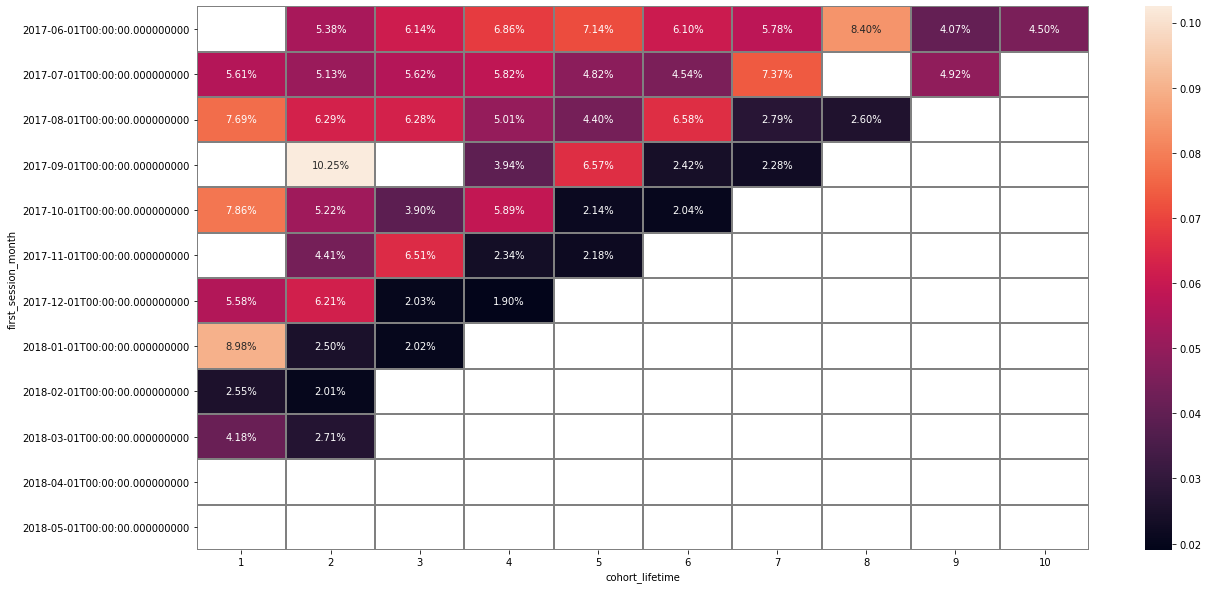

In [176]:
# Создадим когорты
# Создание столбца с нумерацией месяцев с момента первой сессии
visits['cohort_lifetime'] = ((visits['session_month'] - visits['first_session_month']) / np.timedelta64(1,'M')).astype('int')
# Создание когорты
visits_session_cohorts = visits.groupby(['first_session_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
# Создадим датафрейм с отображением числа пользователей на нулевую неделю для каждой когорты
initial_uid_count = visits_session_cohorts[visits_session_cohorts['cohort_lifetime'] == 0][['first_session_month','uid']]
initial_uid_count = initial_uid_count.rename(columns={'uid':'cohort_users'})
# Добавим в когорты информацию о числе пользователей
visits_session_cohorts = visits_session_cohorts.merge(initial_uid_count, on = 'first_session_month')
# Рассчитаем коэффициент удержания
visits_session_cohorts['retention'] = visits_session_cohorts['uid'] / visits_session_cohorts['cohort_users']
# Создадим сводную таблицу, которая покажет изменения коэффициента по когортам
retention_pivot = (visits_session_cohorts
                   .pivot_table(index = 'first_session_month',
                               columns = 'cohort_lifetime',
                               values = 'retention',
                               aggfunc = 'sum'))
plt.figure(figsize=(20, 10))
# Создадим тепловую карту
sns.heatmap(retention_pivot.iloc[:, 1:], annot=True, fmt='.2%', linewidths=1, linecolor='gray');

Рассматривая эту тепловую карту, становится ясно: сайт с каждым новым месяцем теряет все больше своих старых пользователей. 

Конечно, здесь видна, что сначала коэффициент удержания растет, но это вызвано лишь приближением Нового года и, здесь же прекрасно видно то, как после НГ Retention Rate резко падает к февралю.

Также видны пропущенные ячейки, которые появились из-за отстутствия информации(или неправильной подготовкой мной данных)

Посмотрим, будут ли изменения по отдельным устройствам

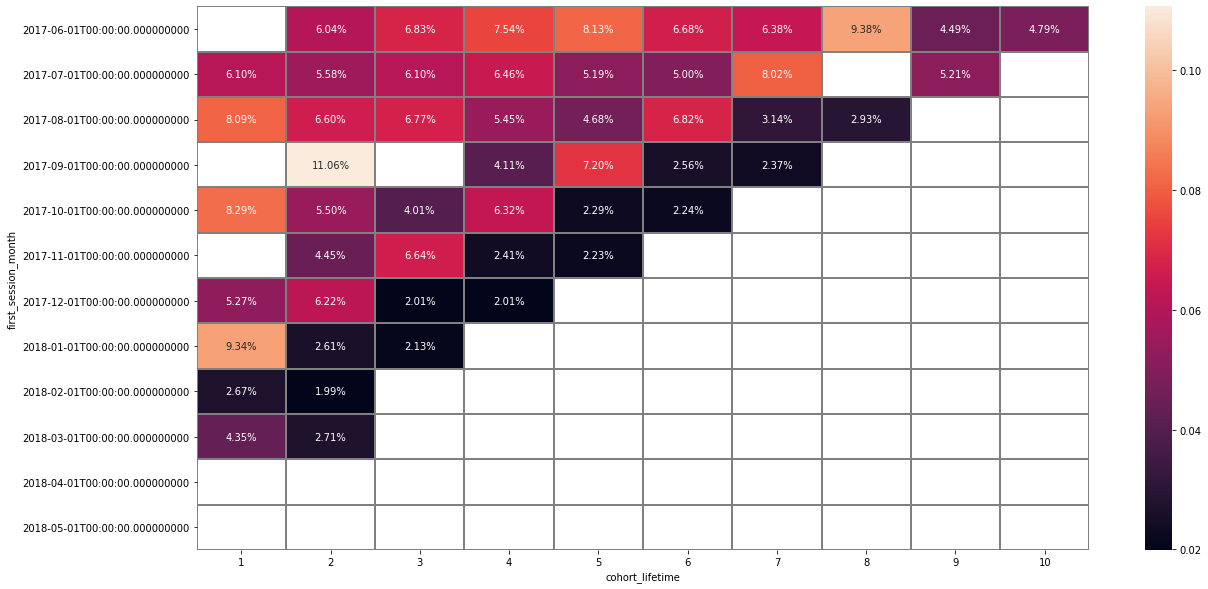

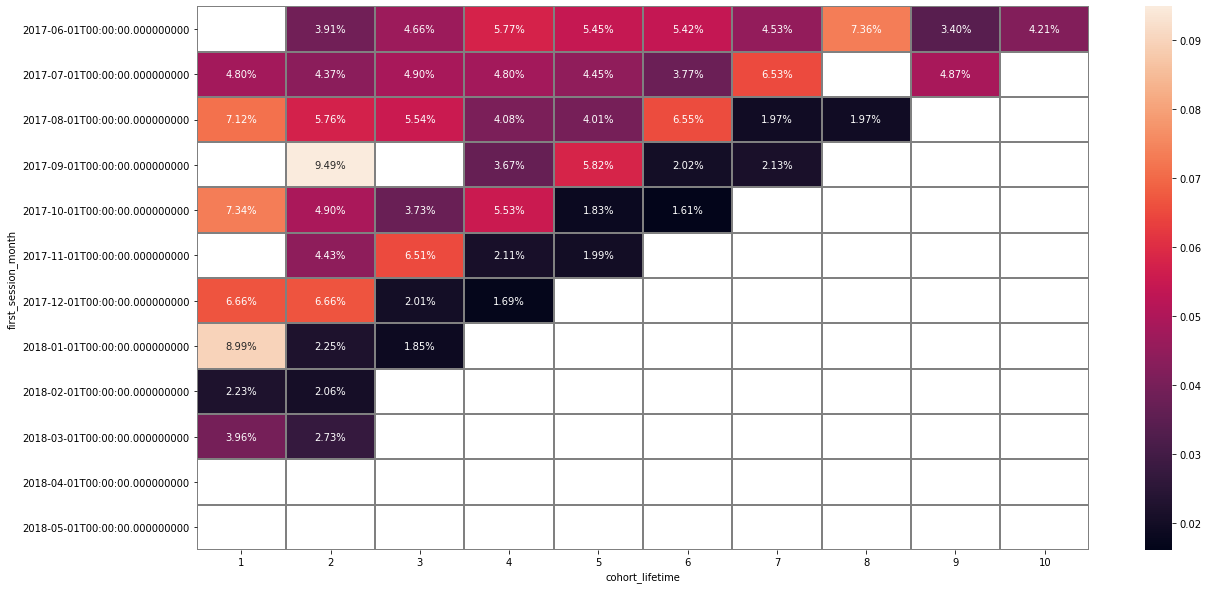

In [177]:
for device in ['desktop', 'touch']:
    device_visits = visits[visits['device'] == device]
    # Создание когорт
    device_session_cohorts = (device_visits
                              .groupby(['first_session_month','cohort_lifetime'])
                              .agg({'uid':'nunique'})
                              .reset_index())
    # Создадим датафрейм с отображением числа пользователей на нулевую неделю для каждой когорты
    device_initial_uid_count = device_session_cohorts[device_session_cohorts['cohort_lifetime'] == 0][['first_session_month','uid']]
    device_initial_uid_count = device_initial_uid_count.rename(columns={'uid':'cohort_users'})
    # Добавим в когорты информацию о числе пользователей
    device_session_cohorts = device_session_cohorts.merge(device_initial_uid_count, on = 'first_session_month')
    # Рассчитаем коэффициент удержания
    device_session_cohorts['retention'] = device_session_cohorts['uid'] / device_session_cohorts['cohort_users']
    # Создадим сводную таблицу, которая покажет изменения коэффициента по когортам
    device_retention_pivot = (device_session_cohorts
                       .pivot_table(index = 'first_session_month',
                                   columns = 'cohort_lifetime',
                                   values = 'retention',
                                   aggfunc = 'sum'))
    plt.figure(figsize=(20, 10))
    # Создадим тепловую карту
    sns.heatmap(device_retention_pivot.iloc[:, 1:], annot=True, fmt='.2%', linewidths=1, linecolor='gray')
    plt.show();

В целом, тенденция уменьшения количества старых пользователей такая же печальная. Изредка происходит скачок посещаемости. Возможно сайт в это время устраивает акции для старых пользователей.

Интересно, Retention Rate пользователей ПК в целом выше маобильных. Возможно, мобильная версия сайта менее привлекательна. Почему ещё, предположить не смогу.

### Когда люди начинают покупать

Найдем время, которое нужно пользователям с момента первой сессии для того, чтобы совершить первую покупку.

In [178]:
# Здесь нам понадобится таблица с информацией о id пользователей и времени их первой покупки
first_order = orders.groupby('uid')['buy_ts'].min()
# Замена имени для последующего соединения таблиц
first_order.name = 'first_order'
first_order

uid
313578113262317        2018-01-03 21:51:00
1575281904278712       2017-06-03 10:13:00
2429014661409475       2017-10-11 18:33:00
2464366381792757       2018-01-28 15:54:00
2551852515556206       2017-11-24 10:14:00
                               ...        
18445147675727495770   2017-11-24 09:03:00
18445407535914413204   2017-09-22 23:55:00
18445601152732270159   2018-03-26 22:54:00
18446156210226471712   2018-02-18 19:34:00
18446167067214817906   2017-10-17 10:16:00
Name: first_order, Length: 36509, dtype: datetime64[ns]

In [179]:
# Джойним к исходной таблице время первой покупки
orders = orders.join(first_order, on = 'uid')
orders.head()

,buy_ts,revenue,uid,first_order
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00


In [180]:
# Найдем дату первого появления пользователя на сайте
first_session = visits.groupby('uid')['start_ts'].min()
# Смена имени объекта для избежания проблем с объединением таблиц
first_session.name = 'first_session'
# Объединим все датафреймы в новом датафрейме
purchases = visits.join(first_order, on = 'uid')
purchases = purchases.join(first_session, on = 'uid')
# Проверим
purchases.head()

,device,end_ts,source_id,start_ts,uid,duration_ts,session_date,session_week,session_month,first_session_month,cohort_lifetime,first_order,first_session
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,1080,2017-12-20,2017-12-14,2017-12-01,2017-12-01,0,NaT,2017-12-20 17:20:00
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,1680,2018-02-19,2018-02-15,2018-02-01,2018-02-01,0,NaT,2018-02-19 16:53:00
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,0,2017-07-01,2017-06-29,2017-07-01,2017-07-01,0,NaT,2017-07-01 01:54:00
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,1440,2018-05-20,2018-05-17,2018-05-01,2018-03-01,2,2018-03-09 20:25:00,2018-03-09 20:05:00
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,0,2017-12-27,2017-12-21,2017-12-01,2017-12-01,0,NaT,2017-12-27 14:06:00


In [181]:
# Найдём время, которое понаобилось пользователю для первой покупки с момента первого появления на сайте
purchases['first_purchase_after'] = purchases['first_order'] - purchases['first_session']
# На всякий случай проверю типы данных
purchases['first_purchase_after'].describe()
# И посмотрю на получившуюся таблицу
purchases

,device,end_ts,source_id,start_ts,uid,duration_ts,session_date,session_week,session_month,first_session_month,cohort_lifetime,first_order,first_session,first_purchase_after
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,1080,2017-12-20,2017-12-14,2017-12-01,2017-12-01,0,NaT,2017-12-20 17:20:00,NaT
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,1680,2018-02-19,2018-02-15,2018-02-01,2018-02-01,0,NaT,2018-02-19 16:53:00,NaT
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,0,2017-07-01,2017-06-29,2017-07-01,2017-07-01,0,NaT,2017-07-01 01:54:00,NaT
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,1440,2018-05-20,2018-05-17,2018-05-01,2018-03-01,2,2018-03-09 20:25:00,2018-03-09 20:05:00,00:20:00
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,0,2017-12-27,2017-12-21,2017-12-01,2017-12-01,0,NaT,2017-12-27 14:06:00,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539,19,2017-07-29,2017-07-27,2017-07-01,2017-07-01,0,2017-07-29 19:07:00,2017-07-29 19:07:00,00:00:00
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586,19,2018-01-25,2018-01-25,2018-01-01,2018-01-01,0,2018-01-25 17:38:00,2018-01-25 17:38:00,00:00:00
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294,19,2018-03-03,2018-03-01,2018-03-01,2018-03-01,0,2018-03-03 10:12:00,2018-03-03 10:12:00,00:00:00
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485,19,2017-11-02,2017-11-02,2017-11-01,2017-11-01,0,2017-11-02 10:12:00,2017-11-02 10:12:00,00:00:00


In [182]:
first_purchase = purchases[['uid','device','first_purchase_after']]
unique_first_purchases = first_purchase.drop_duplicates()
unique_first_purchases['first_purchase_after'] = unique_first_purchases['first_purchase_after'] / np.timedelta64(1, 'D')
unique_first_purchases['first_purchase_after'] = unique_first_purchases['first_purchase_after'].apply('ceil')

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


0    1.0
dtype: float64


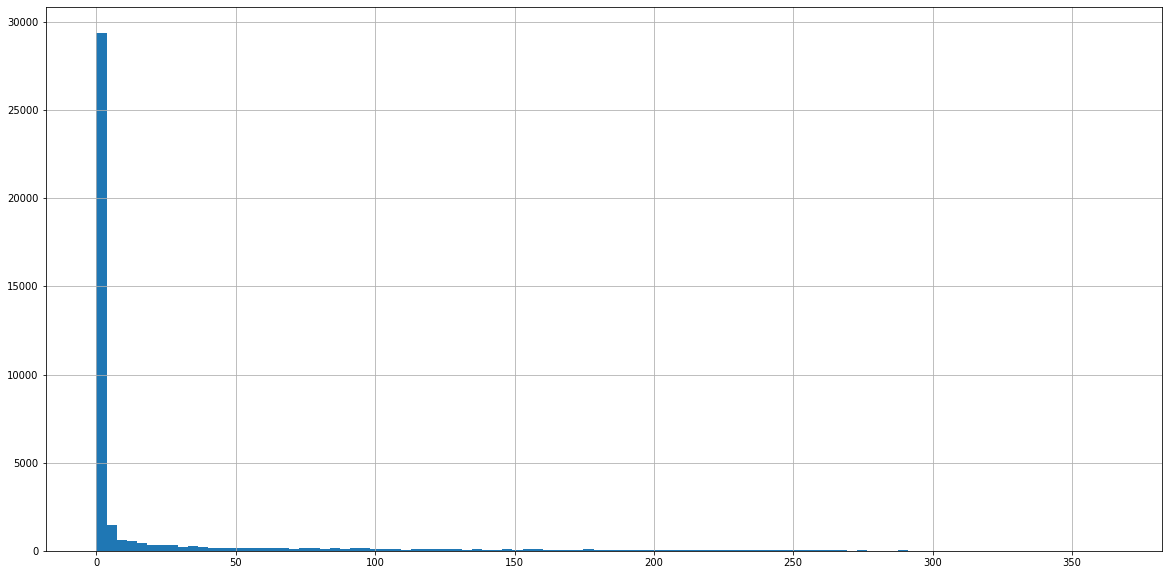

In [183]:
# Посмотрим на распределение времени до первой покупки в днях
plt.figure(figsize=(20, 10))
unique_first_purchases['first_purchase_after'].hist(bins = 100);
print(unique_first_purchases['first_purchase_after'].mode())

Ага, большинство покупок совершается в первые дни. Надо посмотреть на распределение поближе.

1


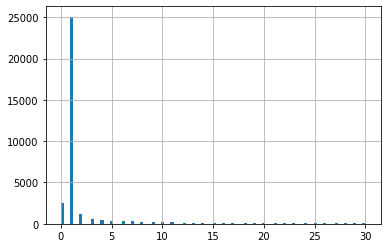

In [184]:
# Делаем то же самое, но сузим диапазон до месяца
unique_first_purchases['first_purchase_after'].hist(bins = 100, range = (0,30));
print(unique_first_purchases['first_purchase_after'].mode()[0].astype('int'))

Как видно, большинство первых покупок совершается **в течении первого дня**. 

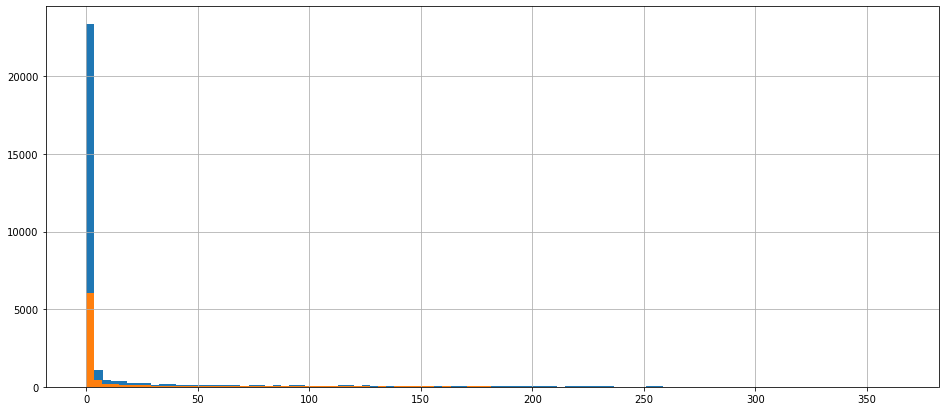

In [185]:
# Посмотрим, есть ли различия в распределении между платформами
plt.figure(figsize=(16, 7))
for device in ['desktop', 'touch']:
    device_purchases = unique_first_purchases[unique_first_purchases['device'] == device]
    device_purchases['first_purchase_after'].hist(bins = 100);

Время необходимое для того чтобы совершить первую покупку не зависит от устройства, на котором эта покупка совершается. Большинство покупок совершается в первый день.

### Сколько раз покупают за период?

Как мы определили раньше, датасет охватывает период ровно в один год. Поэтому правильнее всего разделить этот период на 12 месяцев и смотреть на ежемесяцчные изменения.

In [186]:
# Создадим копию датафрейм заказов
f_orders = orders.copy()
# Найдём количество целых месяцев прошедших с момента покупки
f_orders['age_purchase'] = (orders['buy_ts'] - orders['first_order']) / np.timedelta64(1, 'M')
f_orders['age_purchase'] = f_orders['age_purchase'].round().astype('int')
# Округлим время первой покупки до месяца
f_orders['first_month'] = f_orders['first_order'].astype('datetime64[M]')
f_orders

,buy_ts,revenue,uid,first_order,age_purchase,first_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,0,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,0,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,0,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,0,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,0,2017-06-01
...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31 23:50:00,0,2018-05-01
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31 23:50:00,0,2018-05-01
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31 23:54:00,0,2018-05-01
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-31 23:56:00,0,2018-05-01


In [187]:
# Найдём размеры каждой "возрастной" группы
cohort_sizes = f_orders.groupby('first_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_month', 'n_buyers']
cohort_sizes

,first_month,n_buyers
0,2017-06-01,2022
1,2017-07-01,1922
2,2017-08-01,1369
3,2017-09-01,2579
4,2017-10-01,4340
5,2017-11-01,4078
6,2017-12-01,4380
7,2018-01-01,3373
8,2018-02-01,3651
9,2018-03-01,3534


In [188]:
# Найдём количество покупок с момента первой покупки и до каждого из последующих месяцев
# Сводная таблица в которой считается количество покупок за каждый месяц
result = f_orders.pivot_table(
        index='first_month', 
        columns='age_purchase', 
        values='uid', 
        aggfunc='count').round()
# Приьавление к каждому столбцу количества покупок предыдущего месяца
result = result.cumsum(axis=1)

Далее найду среднее количество покупок одного покупателя. 

Наверняка есть более элегантный способ, но мне в голову пришёл только этот топорный метод

In [189]:
result.columns = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
result

,0,1,2,3,4,5,6,7,8,9,10,11,12
first_month,,,,,,,,,,,,,
2017-06-01,2354.0,2501.0,2652.0,2884.0,3162.0,3365.0,3640.0,3837.0,4048.0,4222.0,4332.0,4394.0,4430.0
2017-07-01,2189.0,2281.0,2394.0,2499.0,2571.0,2638.0,2714.0,2774.0,2825.0,2852.0,2896.0,2909.0,NaN
2017-08-01,1561.0,1659.0,1757.0,1845.0,1911.0,1971.0,2043.0,2101.0,2153.0,2187.0,NaN,NaN,NaN
2017-09-01,2959.0,3154.0,3316.0,3464.0,3544.0,3656.0,3750.0,3809.0,3864.0,3873.0,NaN,NaN,NaN
2017-10-01,4982.0,5256.0,5438.0,5567.0,5692.0,5786.0,5874.0,5968.0,6005.0,NaN,NaN,NaN,NaN
2017-11-01,4930.0,5189.0,5409.0,5589.0,5717.0,5781.0,5858.0,5878.0,NaN,NaN,NaN,NaN,NaN
2017-12-01,5058.0,5300.0,5514.0,5695.0,5776.0,5874.0,5890.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,3807.0,4018.0,4167.0,4242.0,4301.0,4308.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,4101.0,4327.0,4406.0,4463.0,4469.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [190]:
result = result.reset_index()
# Добавим столбец с количеством пользователей
result['n_buyers'] = cohort_sizes['n_buyers']

In [191]:
def kum_sum(row):
    '''
    Функция, делящая количество покупок в каждой строке на количество покупателей
    '''
    for k in range(0,13):
        row[k] = (row[k] / row['n_buyers'])
    return row
# Применяем функцию 
result = result.apply(kum_sum, axis = 1)

In [192]:
result.index = result['first_month']

In [193]:
# Удалим лишние столбцы
result = result[[0,1,2,3,4,5,6,7,8,9,10,11,12]]
result

,0,1,2,3,4,5,6,7,8,9,10,11,12
first_month,,,,,,,,,,,,,
2017-06-01,1.164194,1.236894,1.311573,1.426311,1.563798,1.664194,1.800198,1.897626,2.001978,2.088032,2.142433,2.173096,2.1909
2017-07-01,1.138918,1.186785,1.245578,1.300208,1.337669,1.372529,1.412071,1.443288,1.469823,1.483871,1.506764,1.513528,NaN
2017-08-01,1.140248,1.211833,1.283419,1.347699,1.395909,1.439737,1.492330,1.534697,1.572681,1.597516,NaN,NaN,NaN
2017-09-01,1.147344,1.222955,1.285770,1.343156,1.374176,1.417604,1.454052,1.476929,1.498255,1.501745,NaN,NaN,NaN
2017-10-01,1.147926,1.211060,1.252995,1.282719,1.311521,1.333180,1.353456,1.375115,1.383641,NaN,NaN,NaN,NaN
2017-11-01,1.208926,1.272437,1.326385,1.370525,1.401913,1.417607,1.436488,1.441393,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.154795,1.210046,1.258904,1.300228,1.318721,1.341096,1.344749,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.128669,1.191224,1.235399,1.257634,1.275126,1.277201,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.123254,1.185155,1.206793,1.222405,1.224048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


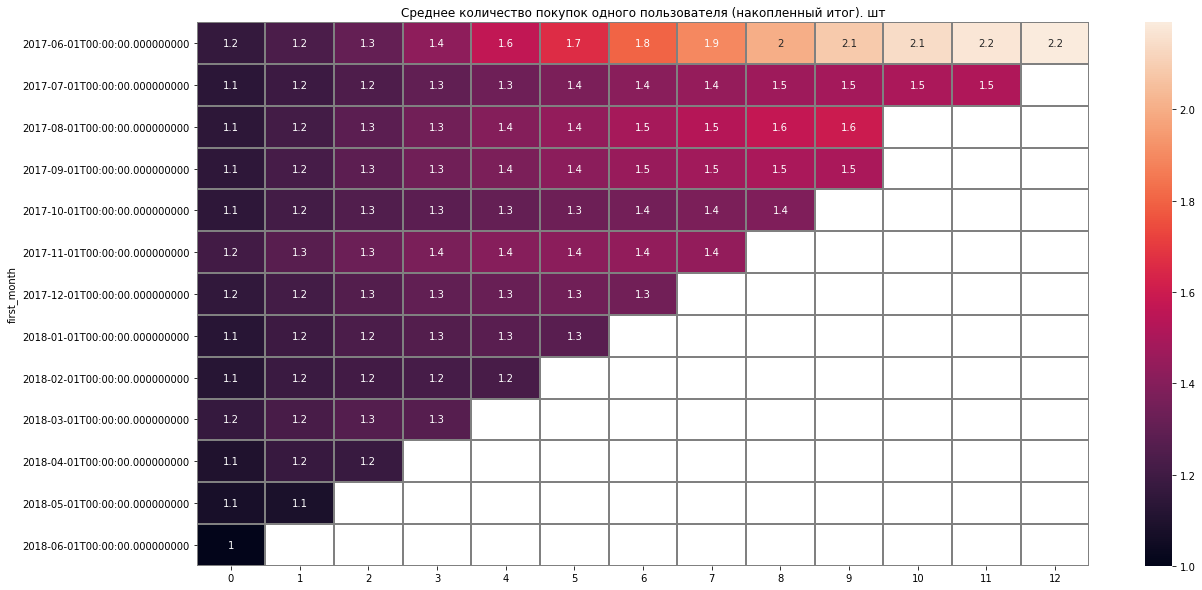

In [194]:
# Создадим тепловую карту среднего количества покупок
plt.figure(figsize=(20, 10))
plt.title('Среднее количество покупок одного пользователя (накопленный итог). шт')
plt.xlabel('Возраст когорты в месяцах')
plt.ylabel('Когорты')
sns.heatmap(result, annot=True, linewidths=1, linecolor='gray');

Получили итоговую тепловую карту которая показывает сколько в среднем делает покупок один пользователь. 

Можно сделать вывод, что подавляющая часть пользователей единожды купив что-то не повторяют больше покупок. это имело бы смысл, если бы сайт предлагал товар или услугу требующую лишь единоразовую покупку, но так как Афиша предлагает билеты, то что-то работает не совсем успешно. Если только весь доход сайта не концентрируется на новых пользователях.

Самая успешная когорта - первая. Она демонстрирует большое количество повторных покупок, что объясняется увеличением среднего количества продаж.

### Величина среднего чека

Расчитаем величину среднего чека. Для этого сгруппируем все продажи по месяцам и посмотрим как величина чека менялась на протяжении года.

Как я понимаю, столбец revenue как раз и показывает величину чеков. Поэтому средний чек будем искать по нему.

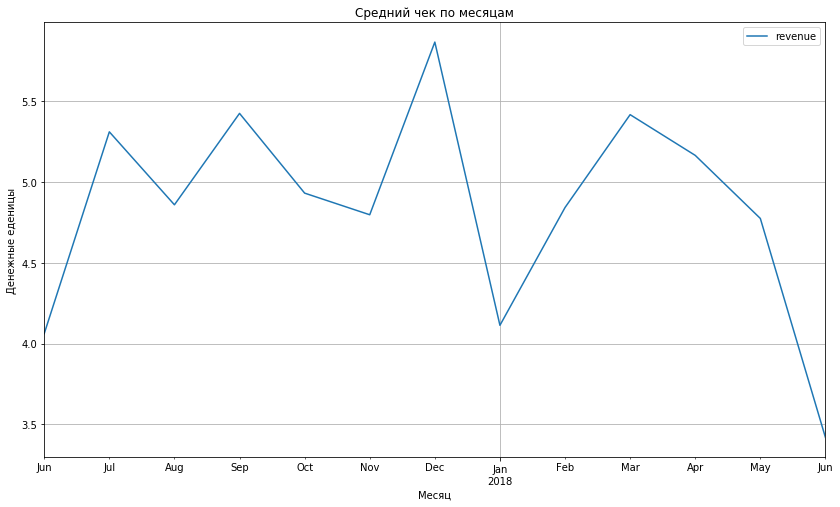

In [195]:
# Столбец с месяцем покупки
orders['purchase_month'] = orders['buy_ts'].astype('datetime64[M]')
# Сводная таблица считающая средний чек каждого месяца
orders.pivot_table(index = 'purchase_month', values = 'revenue', aggfunc = 'mean').plot(figsize = (14,8), grid = True);
plt.title('Средний чек по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Денежные еденицы');

In [196]:
# Величина среднего чека
orders.pivot_table(index = 'purchase_month', values = 'revenue', aggfunc = 'mean').mean()[0]

4.8435954219428785

Посмотрим, какие различия по среднему чеку на разных устройствах.

In [197]:
# Добавим столбец с устройствами
uid_devices = visits.sort_values(by = 'start_ts', ascending = True).groupby(['uid']).agg({'device':'first'})
# Добавим устройства соответствующее пользователю в столбец с заказами
orders_device = pd.merge(left = orders, right = uid_devices, how = 'left', on = 'uid')

Средний чек пользователей : device
desktop    4.982266
touch      4.319129
dtype: float64


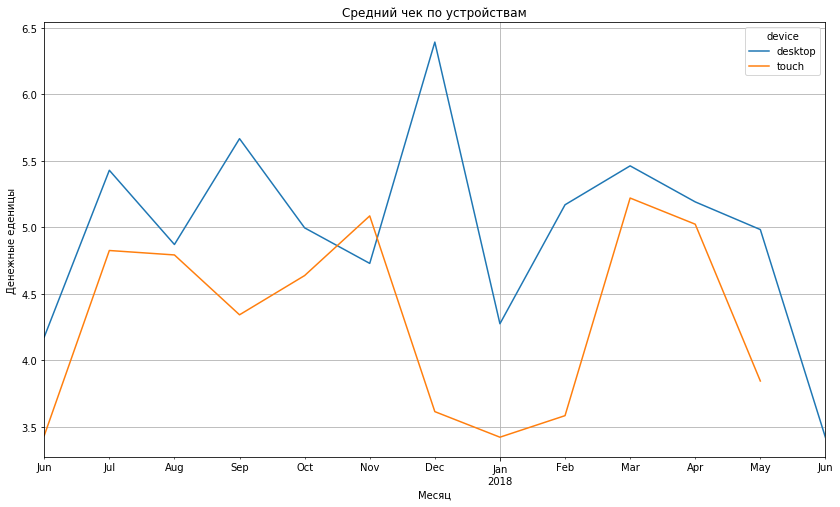

In [198]:
# Покажем изменения величины среднего чека разделенным по устройствам
(orders_device
 .pivot_table(index = 'purchase_month', columns = 'device', values = 'revenue', aggfunc = 'mean')
 .plot(figsize = (14,8), grid = True));
print('Средний чек пользователей :', orders_device.pivot_table(index = 'purchase_month', columns = 'device', values = 'revenue', aggfunc = 'mean').mean())
plt.title('Средний чек по устройствам')
plt.xlabel('Месяц')
plt.ylabel('Денежные еденицы');

Странно, что средний чек на телефонах меньше. Не могу придумать причину этого. Пользователи телефонов боятся совершать дорогие покупки через мобильный? Не уверен.
Более странно, что у пользователей телефонов средний чек в декабре перед Новым годом меньше ноябрьского. Может ошибся с определением девайсов по ID.

### Расчет LTV.

**LTV** (от англ. _lifetime value_) — «пожизненная» ценность клиента. Это — итоговая сумма денег, которую один клиент приносит в среднем со всех своих покупок.

LTV удобно считать по когортам. Все также по месячным

In [199]:
# Создадим новый датафрейм для дальнейшего расчета LTV
LTV_orders = orders.copy()
LTV_orders['first_order'] = LTV_orders['first_order'].astype('datetime64[M]')

In [200]:
# Создадим датафрейм соответствия id пользователя с идентификаторами рекламного источника, из которого пришел пользователь 
source_uid = visits[['uid','source_id']]
source_uid_rt = source_uid.groupby(['uid'])['source_id'].first()

In [201]:
# Добавим в датафрейм информацию о рекламных источниках
LTV_orders = LTV_orders.merge(source_uid_rt, on = 'uid')
LTV_orders

,buy_ts,revenue,uid,first_order,purchase_month,source_id
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,3
...,...,...,...,...,...,...
50359,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-01,2018-05-01,4
50360,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-01,2018-05-01,10
50361,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-01,2018-05-01,3
50362,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-01,2018-05-01,4


In [202]:
# Количество уникальных покупателей
LTV_cohort_sizes = LTV_orders.groupby('first_order').agg({'uid': 'nunique'}).reset_index()
LTV_cohort_sizes.columns = ['first_order', 'unique_buyers']
LTV_cohort_sizes

,first_order,unique_buyers
0,2017-06-01,2022
1,2017-07-01,1922
2,2017-08-01,1369
3,2017-09-01,2579
4,2017-10-01,4340
5,2017-11-01,4078
6,2017-12-01,4380
7,2018-01-01,3373
8,2018-02-01,3651
9,2018-03-01,3534


In [203]:
# Узнаем сумму выручки приходящей каждый день от пользователей пришедших из различных рекламных источников
LTV_cohorts = LTV_orders.groupby(['first_order','purchase_month','source_id']).agg({'revenue': 'sum'}).reset_index()
LTV_cohorts.head()

,first_order,purchase_month,source_id,revenue
0,2017-06-01,2017-06-01,1,1168.45
1,2017-06-01,2017-06-01,2,1551.76
2,2017-06-01,2017-06-01,3,2466.71
3,2017-06-01,2017-06-01,4,2039.64
4,2017-06-01,2017-06-01,5,1787.68


In [204]:
# Добавим информацию о выручке в когортный отчет
LTV_report = pd.merge(LTV_cohort_sizes, LTV_cohorts, on = 'first_order')
LTV_report.head()

,first_order,unique_buyers,purchase_month,source_id,revenue
0,2017-06-01,2022,2017-06-01,1,1168.45
1,2017-06-01,2022,2017-06-01,2,1551.76
2,2017-06-01,2022,2017-06-01,3,2466.71
3,2017-06-01,2022,2017-06-01,4,2039.64
4,2017-06-01,2022,2017-06-01,5,1787.68


Выручка для когорт посчитана, но LTV считают не из выручки, а из валовой прибыли. Значит, нужно найти валовую прибыль, умножив выручку на маржинальность. Так как информации о маржинальности нет в задании, то принимаем её равной единице.

И после найдём LTV. Разделим валовую прибыль когорт за каждый месяц на общее число пользователей в каждой когорте.

In [205]:
# Коэфиициент маржинальности
margin_rate = 1
# Считаем валовую прибыль
LTV_report['gp'] = LTV_report['revenue'] * margin_rate
# Обозначим возрастные когорты
LTV_report['age'] = (LTV_report['purchase_month'] - LTV_report['first_order']) / np.timedelta64(1, 'M')
LTV_report['age'] = LTV_report['age'].round().astype('int')
# Рассчитаем LTV каждого клиента
LTV_report['ltv'] = LTV_report['gp'] / LTV_report['unique_buyers']

In [206]:
LTV_report

,first_order,unique_buyers,purchase_month,source_id,revenue,gp,age,ltv
0,2017-06-01,2022,2017-06-01,1,1168.45,1168.45,0,0.577868
1,2017-06-01,2022,2017-06-01,2,1551.76,1551.76,0,0.767438
2,2017-06-01,2022,2017-06-01,3,2466.71,2466.71,0,1.219936
3,2017-06-01,2022,2017-06-01,4,2039.64,2039.64,0,1.008724
4,2017-06-01,2022,2017-06-01,5,1787.68,1787.68,0,0.884115
...,...,...,...,...,...,...,...,...
510,2018-05-01,2986,2018-05-01,4,3616.23,3616.23,0,1.211062
511,2018-05-01,2986,2018-05-01,5,2103.24,2103.24,0,0.704367
512,2018-05-01,2986,2018-05-01,9,200.38,200.38,0,0.067106
513,2018-05-01,2986,2018-05-01,10,478.93,478.93,0,0.160392


Для наглядности визуализируем когорты в виде сводной таблицы

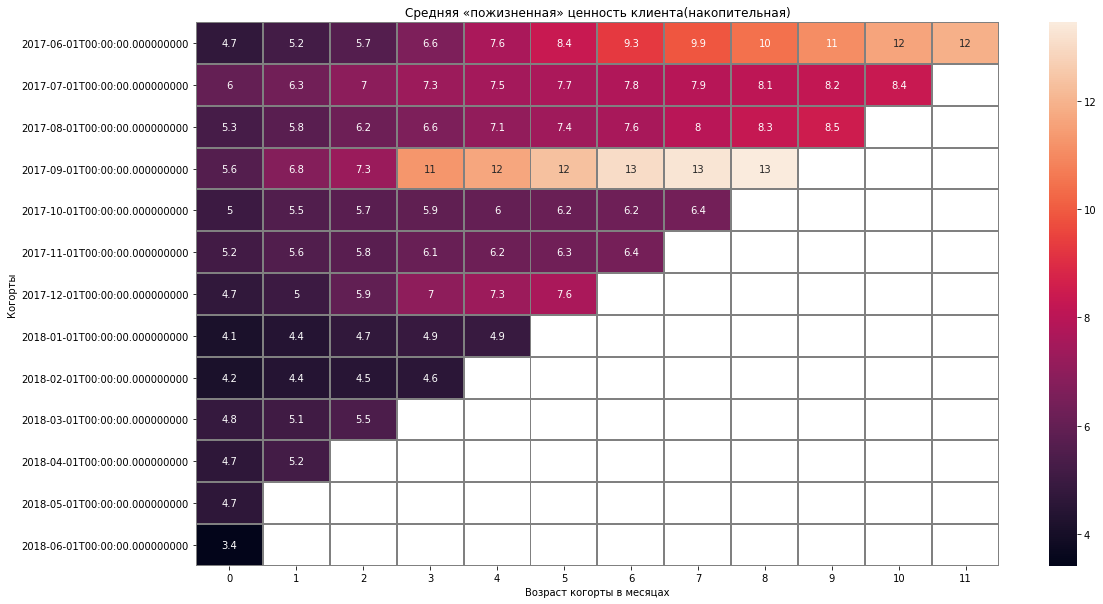

In [207]:
# Создадим хитмап с информацией о LTV клиента за выбранный период
LTV_result = LTV_report.pivot_table(
        index='first_order', 
        columns='age', 
        values='ltv', 
        aggfunc='sum').cumsum(axis = 1)
plt.figure(figsize = (18,10))
sns.heatmap(LTV_result, annot=True, linewidths=1, linecolor='gray');
plt.title('Средняя «пожизненная» ценность клиента(накопительная)')
plt.xlabel('Возраст когорты в месяцах')
plt.ylabel('Когорты');

Самые ценные клиенты находятся в первой и четвертой когорте. И если для первой всё логично, так как она самая "возрастная", то у четвертой LTV в целом растет быстрее всех остальных. Поэтому можно её объявить её самой ценной. Хотя сперва посмотрим тщательнее.

In [208]:
# Посчитаем средний LTV за 6 месяцев
print('Средний LTV за 6 месяцев после первой покупки:',LTV_result.mean(axis=0)[5])

Средний LTV за 6 месяцев после первой покупки: 7.973688716354336


In [209]:
# Разделим заказы по устройствам
device_orders = orders_device.copy()
device_orders['first_order'] = device_orders['first_order'].astype('datetime64[M]')

Средний LTV пользователей desktop за 6 месяцев после первой покупки: 8.43102084496002


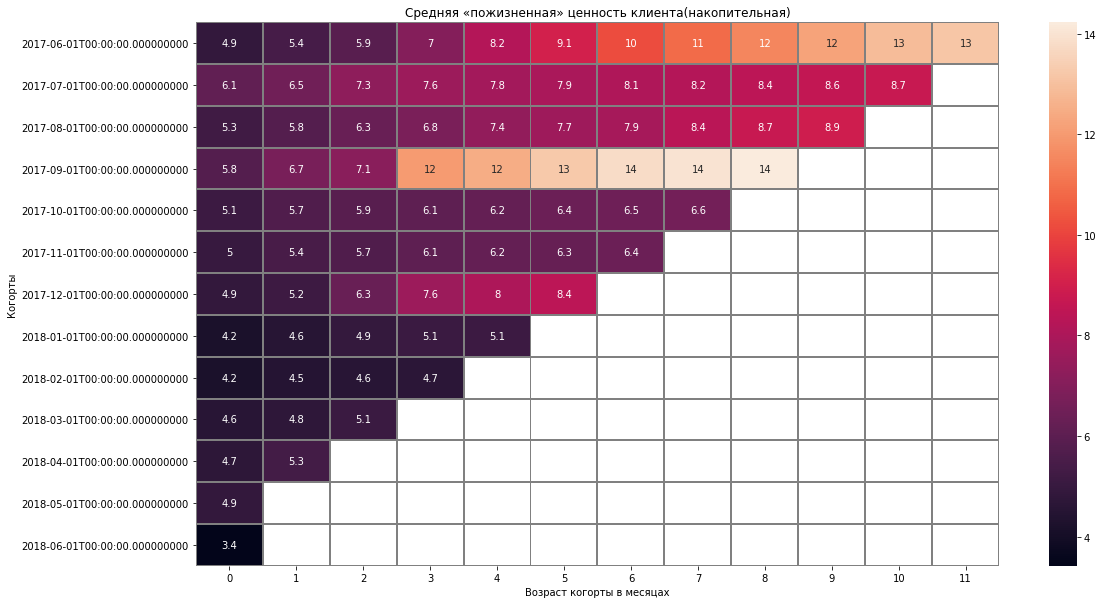

Средний LTV пользователей touch за 6 месяцев после первой покупки: 6.00817635363845


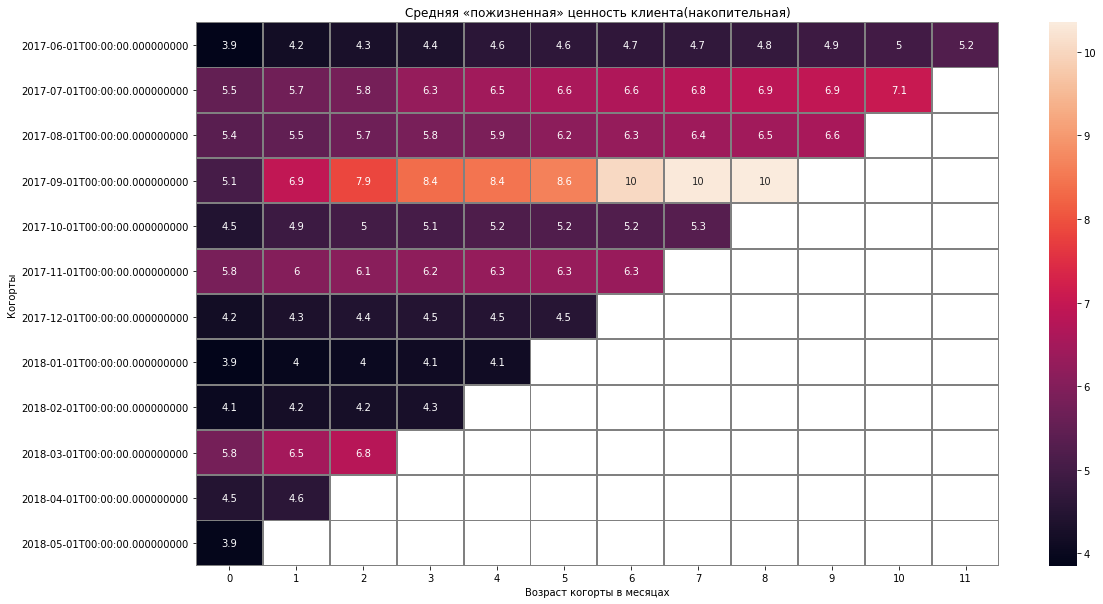

In [210]:
for device in ['desktop', 'touch']:
    '''
    Цикл для построения хитмапа LTV по различным устройствам
    '''
    # Создание среза включающее только нужные девайсы
    LTV_device_orders = device_orders[device_orders['device'] == device]
    # Размеры когорт данного среза
    LTV_cohort_sizes = LTV_device_orders.groupby('first_order').agg({'uid': 'nunique'}).reset_index()
    LTV_cohort_sizes.columns = ['first_order', 'unique_buyers']
    # Группировка когорт
    LTV_cohorts = LTV_device_orders.groupby(['first_order','purchase_month',]).agg({'revenue': 'sum'}).reset_index()
    # Формирование отчета о выручке
    LTV_report_device = pd.merge(LTV_cohort_sizes, LTV_cohorts, on = 'first_order')
    # Расчет LTV
    margin_rate = 1
    LTV_report_device['gp'] = LTV_report_device['revenue'] * margin_rate
    LTV_report_device['age'] = (LTV_report_device['purchase_month'] - LTV_report_device['first_order']) / np.timedelta64(1, 'M')
    LTV_report_device['age'] = LTV_report_device['age'].round().astype('int')
    LTV_report_device['ltv'] = LTV_report_device['gp'] / LTV_report_device['unique_buyers']
    # Сводная таблица с информацие о среднем LTV для устройства
    LTV_result = LTV_report_device.pivot_table(
        index='first_order', 
        columns='age', 
        values='ltv', 
        aggfunc='sum').cumsum(axis = 1)
    plt.figure(figsize = (18,10))
    # Создание хитмапа
    sns.heatmap(LTV_result, annot=True, linewidths=1, linecolor='gray');
    plt.title('Средняя «пожизненная» ценность клиента(накопительная)')
    plt.xlabel('Возраст когорты в месяцах')
    plt.ylabel('Когорты');
    # Средний LTV за 6 месяцев
    print('Средний LTV пользователей', device,'за 6 месяцев после первой покупки:',LTV_result.mean(axis=0)[5])
    plt.show()
    

Четвёртая когорта определенно самая ценная. Она впереди на всех платформах. Первую же когорту вытягивает наверх только ПК.

Нам также нужно посмотреть LTV по источникам. Для этого нам требуется создать столбец с рекламным источником, откуда пришёл пользователь

Средний LTV пользователей 1 источника за 6 месяцев после первой покупки: 10.688088276511053


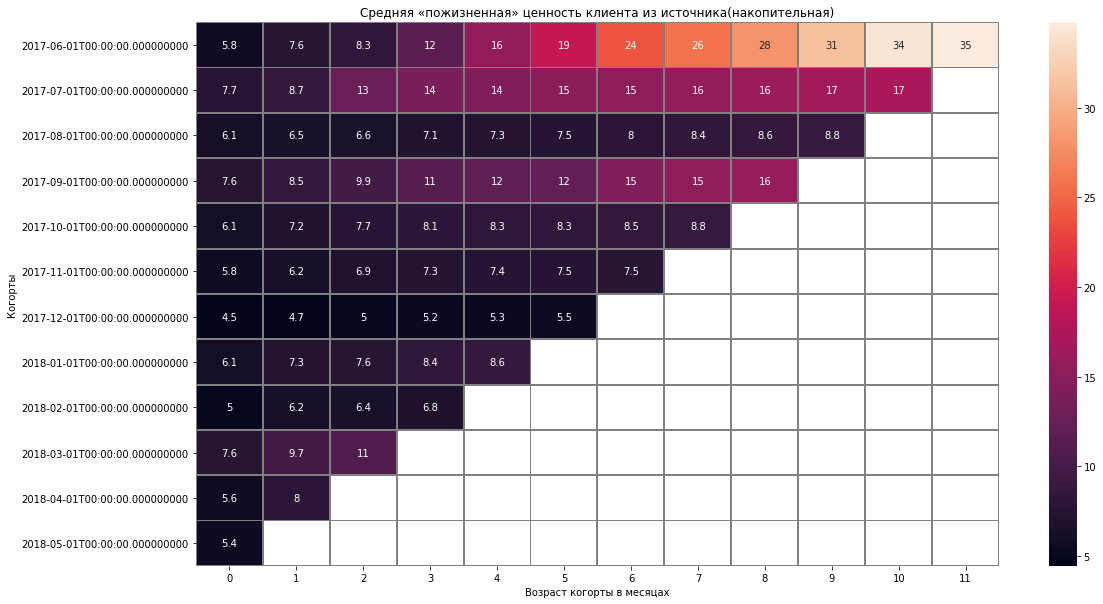

Средний LTV пользователей 2 источника за 6 месяцев после первой покупки: 19.630037868233746


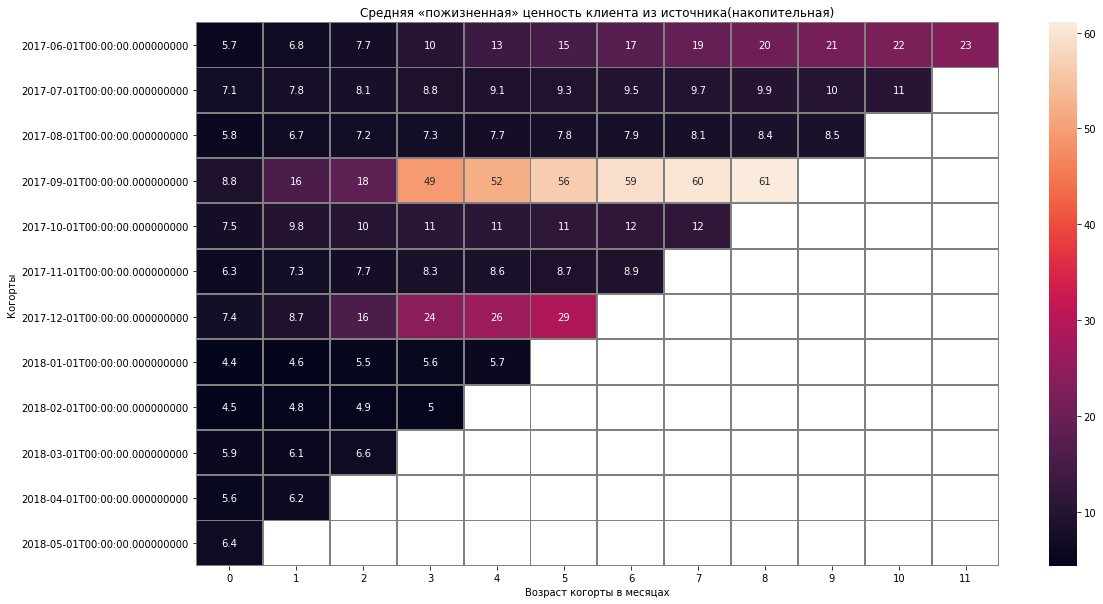

Средний LTV пользователей 3 источника за 6 месяцев после первой покупки: 5.335416828386824


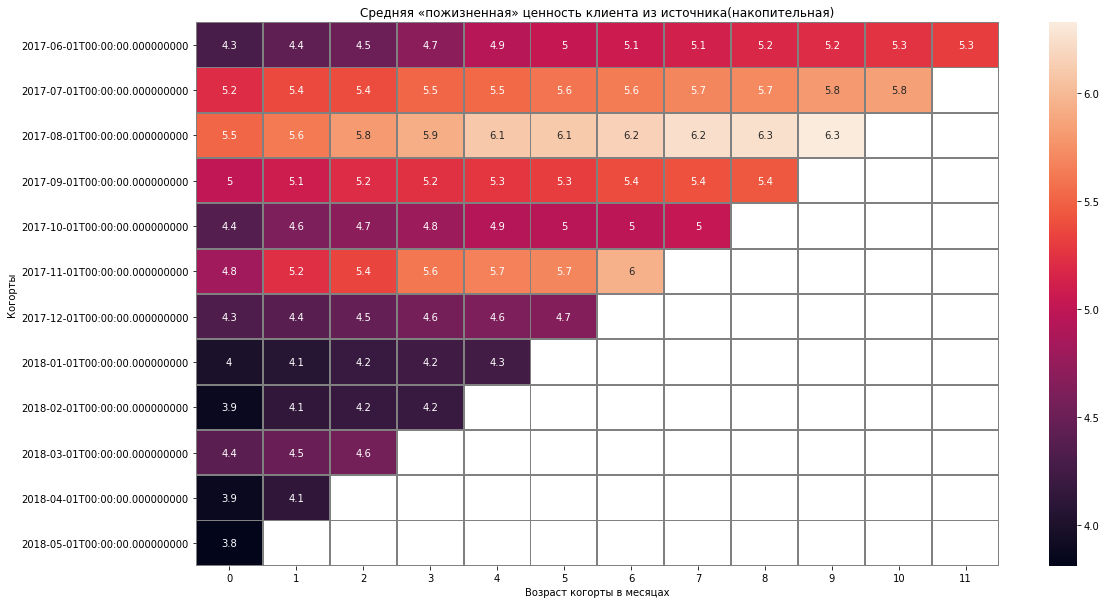

Средний LTV пользователей 4 источника за 6 месяцев после первой покупки: 5.887698248091719


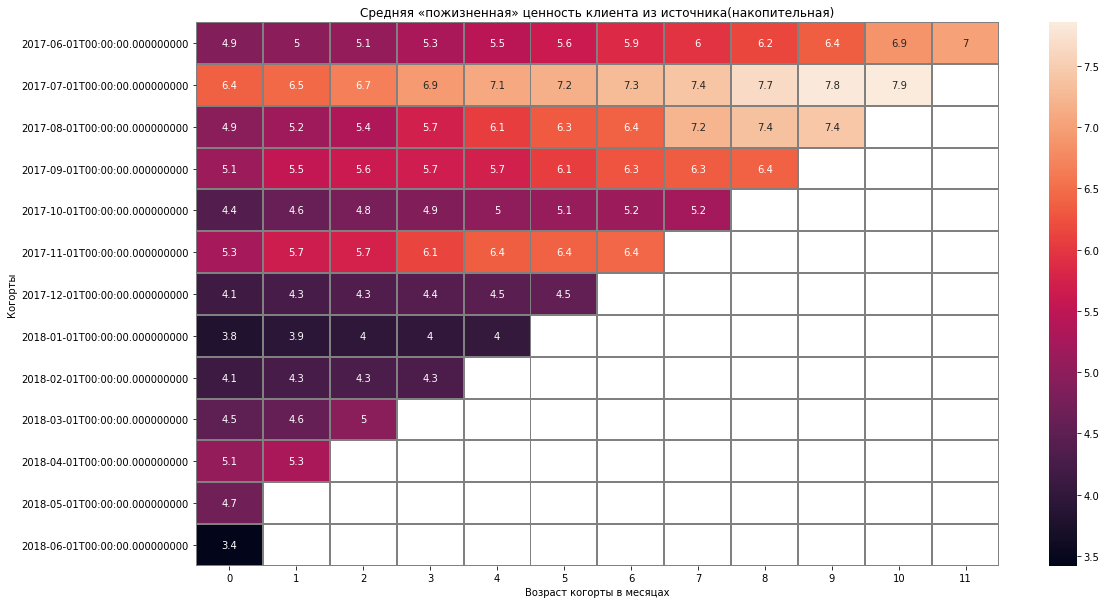

Средний LTV пользователей 5 источника за 6 месяцев после первой покупки: 6.57977061167375


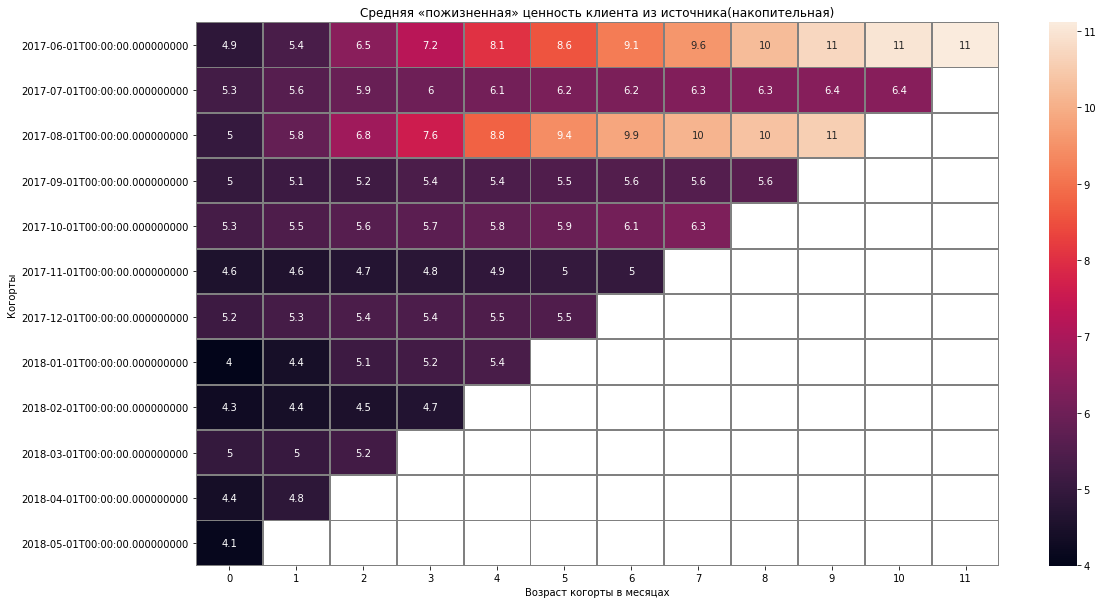

Средний LTV пользователей 9 источника за 6 месяцев после первой покупки: 5.660049267280766


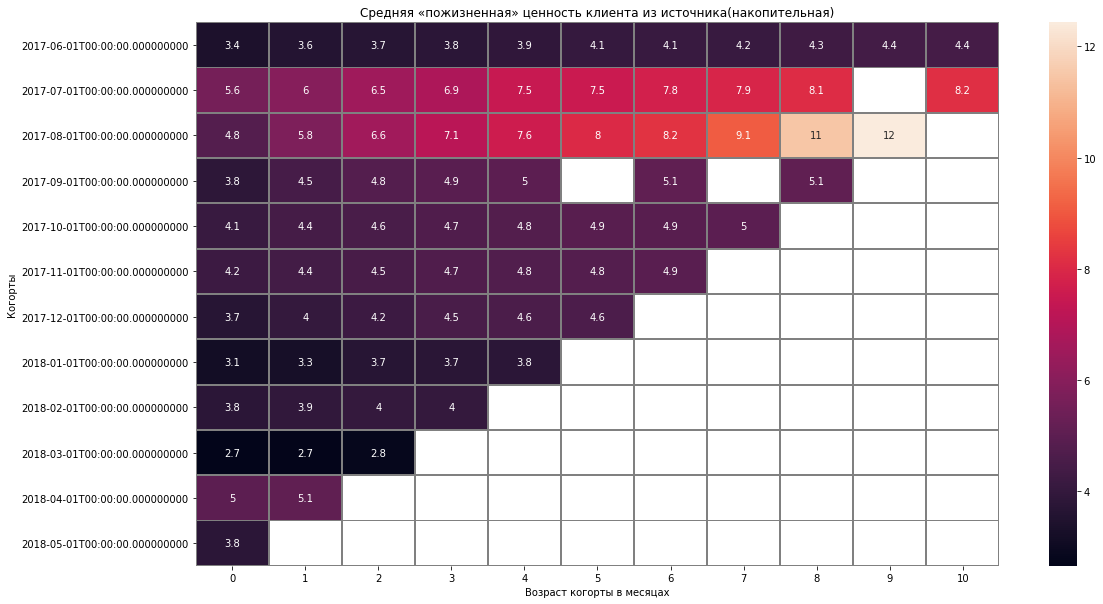

Средний LTV пользователей 10 источника за 6 месяцев после первой покупки: 3.7506448507330874


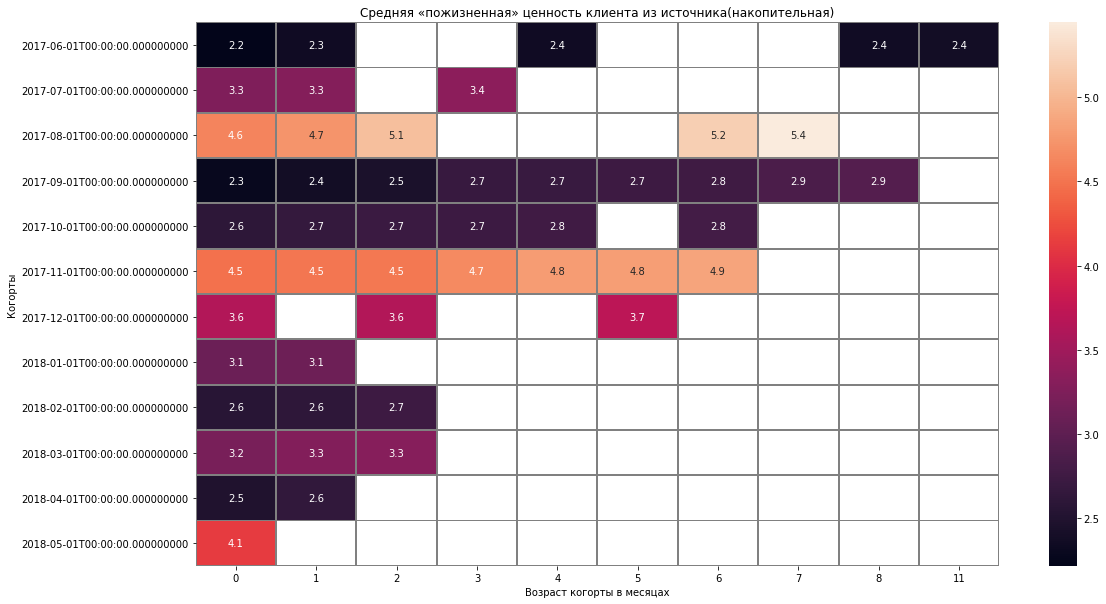

In [211]:
for source_id in [1,2,3,4,5,9,10]:
    '''
    Цикл для построения хитмапа LTV по различным рекламным источникам
    '''
    # Создание среза включающее только нужные источники
    LTV_source_orders = LTV_orders[LTV_orders['source_id'] == source_id].copy()
    # Размеры когорт данного среза
    LTV_source_cohort_sizes = LTV_source_orders.groupby('first_order').agg({'uid': 'nunique'}).reset_index()
    LTV_source_cohort_sizes.columns = ['first_order', 'unique_buyers']
    # Группировка когорт
    LTV_source_cohorts = LTV_source_orders.groupby(['first_order','purchase_month',]).agg({'revenue': 'sum'}).reset_index()
    # Формирование отчета о выручке
    LTV_source_report = pd.merge(LTV_source_cohort_sizes, LTV_source_cohorts, on = 'first_order')
    # Расчет LTV
    margin_rate = 1
    LTV_source_report['gp'] = LTV_source_report['revenue'] * margin_rate
    LTV_source_report['age'] = (LTV_source_report['purchase_month'] - LTV_source_report['first_order']) / np.timedelta64(1, 'M')
    LTV_source_report['age'] = LTV_source_report['age'].round().astype('int')
    LTV_source_report['ltv'] = LTV_source_report['gp'] / LTV_source_report['unique_buyers']
    # Сводная таблица с информацие о среднем LTV для источника
    LTV_source_result = LTV_source_report.pivot_table(
        index='first_order', 
        columns='age', 
        values='ltv', 
        aggfunc='sum').cumsum(axis = 1)
    plt.figure(figsize = (18,10))
    # Создание хитмапа
    sns.heatmap(LTV_source_result, annot=True, linewidths=1, linecolor='gray');
    plt.title('Средняя «пожизненная» ценность клиента из источника(накопительная)')
    plt.xlabel('Возраст когорты в месяцах')
    plt.ylabel('Когорты');
    # Средний LTV за 6 месяцев
    print('Средний LTV пользователей', source_id,'источника за 6 месяцев после первой покупки:',LTV_source_result.mean(axis=0)[5])
    plt.show()

### Вывод

Данный пункт был посвящён метрикам связанным с покупателями и их покупками. 

Были получены следующин выводы:

- **Когда люди начинают покупать?** В большинстве случаев, люди совершают покупки на сайте в течении первого дня, в который они впервые зашли на сайт. Если смотреть на общую картину, то продажи резко увеличиваются перед Новым годом, что весьма логично. 

- **Сколько раз покупают за период?** Большая часть пользователей не совершает больше 2 покупок на сайте за год. При ознакомлении с данными заметил несколько пользователей совершившие более сотни покупок. Они вытягивают среднее количество покупок вверх.

- **Какой средний чек?**  Средний чек по всему датасету составляет 4,84 д.е. Средний чек резко возрастает перед Новым годом.

- **Сколько денег приносят?** Был посчитан срдений LTV. Он составляет 6 д.е.Были найдены самые ценные пользовательские когорты и найдены зависимости от платформы и источника.

## Маркетинг

Здесь рассмотрим общие затраты на маркетинг, стоимость привлечения одного покупателя и окупаемость расходов(ROI). Посмотрим как 
ти показатели зависисят от рекланых источников.

Основной таблицей в данных расчетах является датафрейм **_costs_**.

### Общие затраты на маркетинг

Найдём суммарные затраты на маркетинг разбитый по дням на протяжении всего года. Посмотрим, как они меняются в зависимости от времени и рекламных источников.

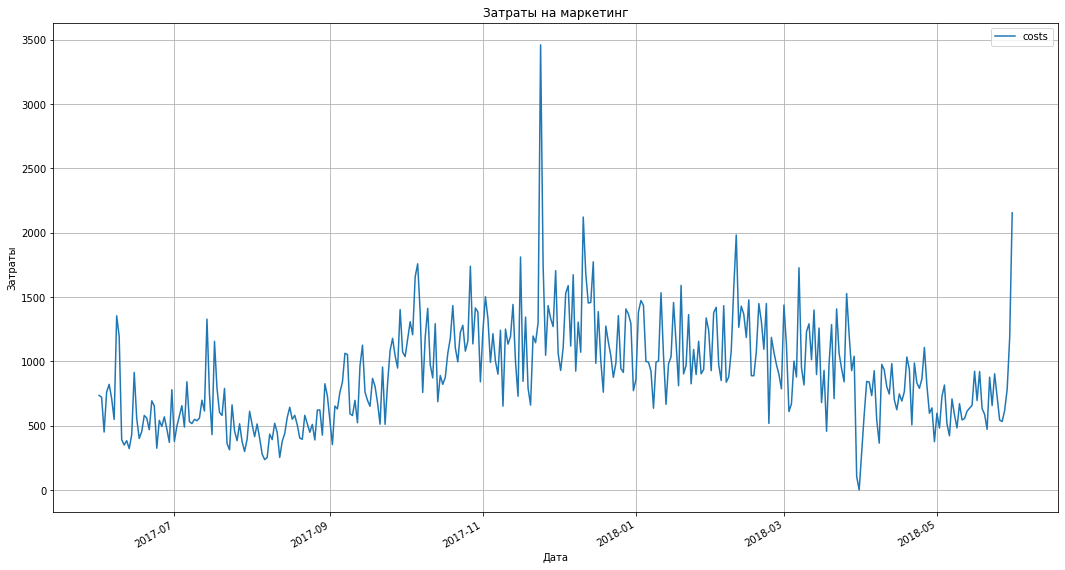

In [212]:
# С помощью группировки сразу посмотрим на зависимость затрат от времени
costs.groupby('dt').agg({'costs':'sum'}).plot(figsize = (18,10), grid = True)
plt.title('Затраты на маркетинг')
plt.xlabel('Дата')
plt.ylabel('Затраты');

Виден пик, остальное размыто. Этот график будет выглядеть лучше, если мы проведем суммирование по месяцам

In [213]:
# Создадим новый датафрейм из таблицы о затратах
costs_month = costs.copy()
costs_month['dt'] = costs_month['dt'].astype('datetime64[M]')
costs_month

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-01,62.25
2,1,2017-06-01,36.53
3,1,2017-06-01,55.00
4,1,2017-06-01,57.08
...,...,...,...
2537,10,2018-05-01,9.92
2538,10,2018-05-01,21.26
2539,10,2018-05-01,11.32
2540,10,2018-05-01,33.15


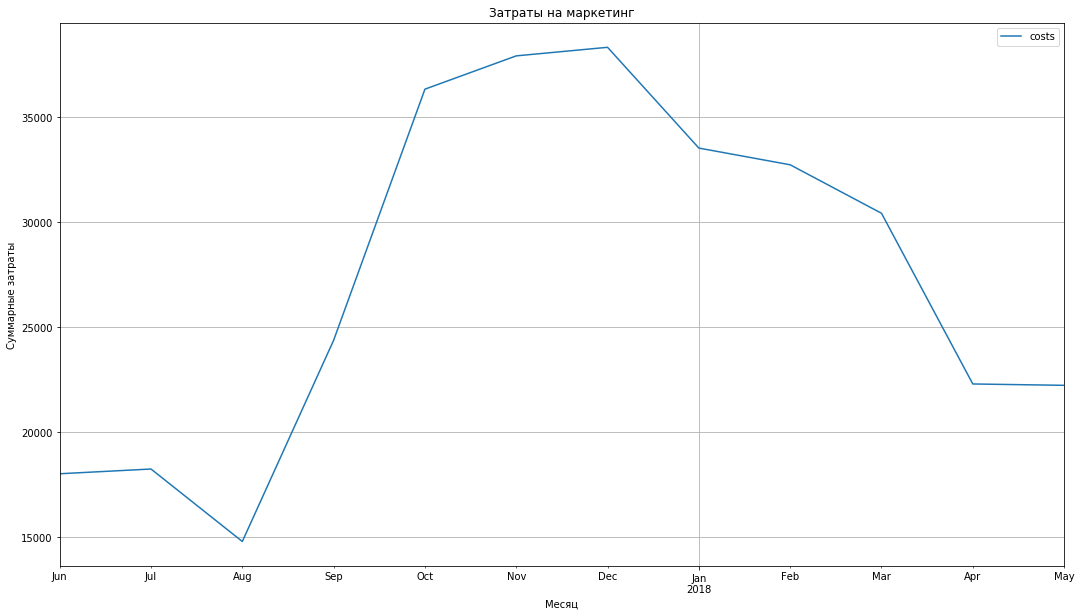

In [214]:
# Создадим сводную таблицу для просмотра общих затрат на маркетинг
costs_month.pivot_table(index = 'dt', values = 'costs',
                  aggfunc = 'sum').plot(figsize = (18,10), grid = True)
plt.title('Затраты на маркетинг')
plt.xlabel('Месяц')
plt.ylabel('Суммарные затраты');
monthly_costs = costs_month.pivot_table(index = 'dt', values = 'costs', aggfunc = 'sum')

Затраты на маркетинг вырастают почти в 2 раза перед Новым годом. Все знают, что в это время люди трятят больше денег, поэтому и вкладывают в рекламу именно в этот срок.

Узнаем, какие источники тратят больше всего денег.

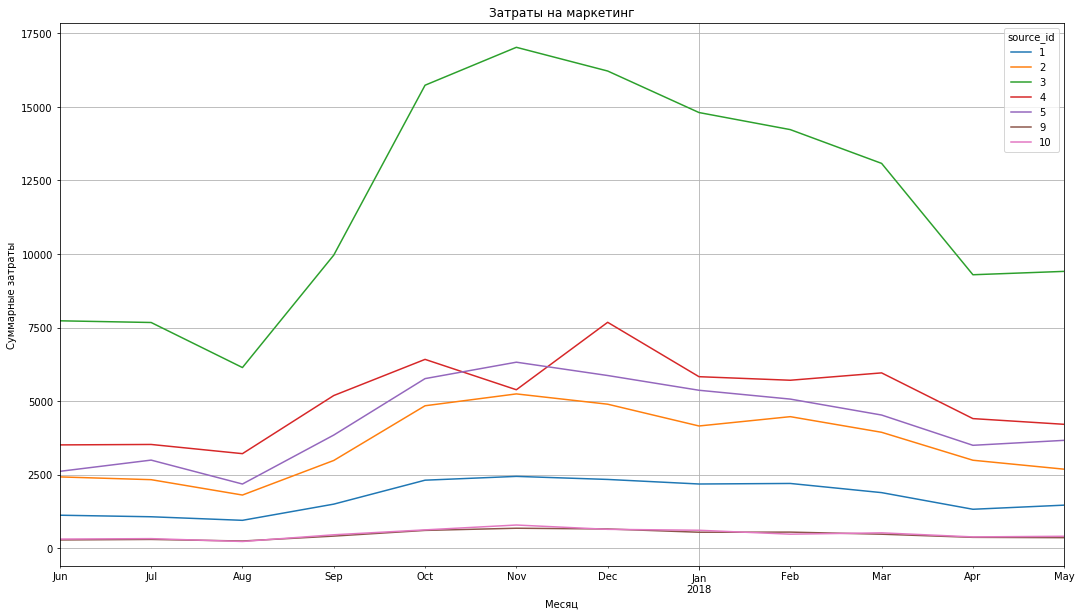

In [215]:
# Создадим сводную таблицу для просмотра влияния источника рекламы на маркетинг
costs_month.pivot_table(index = 'dt', values = 'costs', columns = 'source_id',
                  aggfunc = 'sum').plot(figsize = (18,10), grid = True)
plt.title('Затраты на маркетинг')
plt.xlabel('Месяц')
plt.ylabel('Суммарные затраты');

In [216]:
# Найдём сумму всех потраченных денег
print('Всего за данный период на маркетинг было потрачено',costs['costs'].sum(),'денежных единиц')

Всего за данный период на маркетинг было потрачено 329131.62 денежных единиц


In [217]:
costs_month.pivot_table(index = 'dt', values = 'costs', columns = 'source_id',aggfunc = 'sum').sum()

source_id
1      20833.27
2      42806.04
3     141321.63
4      61073.60
5      51757.10
9       5517.49
10      5822.49
dtype: float64

Видим, что источник #3 вкладывает больше всего денег в маркетинг. Его затраты составляют почти 50% от суммарных затрат. При этом их выручка не выделяется по сравнению с другими источниками. Можно забежать вперед и сказать, что это не самый эффективный в плане вложения денег источник для увеличения продаж.

### Сколько стоило привлечение одного покупателя из каждого источника? CAC


**CAC** (от англ. _customer acquisition cost_ ) — стоимость привлечения клиента. Сумма денег, во сколько обходится новый клиент компании.

In [218]:
# Добавим данные о расходах в отчёт и посчитаем CAC:
report_new = pd.merge(LTV_report, monthly_costs, left_on='first_order', right_on='dt')
report_new['age'].value_counts()

0     85
1     76
2     67
3     58
4     52
5     44
6     40
7     31
8     26
9     17
10    12
11     6
Name: age, dtype: int64

In [219]:
report_new['cac'] = report_new['costs'] / report_new['unique_buyers']
# Не отходя от кассы посчитаем окупаемость рекламных затрат на будущее
report_new['romi'] = report_new['ltv'] / report_new['cac']
report_new

,first_order,unique_buyers,purchase_month,source_id,revenue,gp,age,ltv,costs,cac,romi
0,2017-06-01,2022,2017-06-01,1,1168.45,1168.45,0,0.577868,18015.00,8.909496,0.064860
1,2017-06-01,2022,2017-06-01,2,1551.76,1551.76,0,0.767438,18015.00,8.909496,0.086137
2,2017-06-01,2022,2017-06-01,3,2466.71,2466.71,0,1.219936,18015.00,8.909496,0.136925
3,2017-06-01,2022,2017-06-01,4,2039.64,2039.64,0,1.008724,18015.00,8.909496,0.113219
4,2017-06-01,2022,2017-06-01,5,1787.68,1787.68,0,0.884115,18015.00,8.909496,0.099233
...,...,...,...,...,...,...,...,...,...,...,...
509,2018-05-01,2986,2018-05-01,3,2990.65,2990.65,0,1.001557,22224.27,7.442823,0.134567
510,2018-05-01,2986,2018-05-01,4,3616.23,3616.23,0,1.211062,22224.27,7.442823,0.162715
511,2018-05-01,2986,2018-05-01,5,2103.24,2103.24,0,0.704367,22224.27,7.442823,0.094637
512,2018-05-01,2986,2018-05-01,9,200.38,200.38,0,0.067106,22224.27,7.442823,0.009016


Средняя стоимость привлечения одного пользователя из источника 1 равна: 0.019
Средняя стоимость привлечения одного пользователя из источника 2 равна: 0.041
Средняя стоимость привлечения одного пользователя из источника 3 равна: 0.136
Средняя стоимость привлечения одного пользователя из источника 4 равна: 0.036
Средняя стоимость привлечения одного пользователя из источника 5 равна: 0.045
Средняя стоимость привлечения одного пользователя из источника 9 равна: 0.006
Средняя стоимость привлечения одного пользователя из источника 10 равна: 0.005


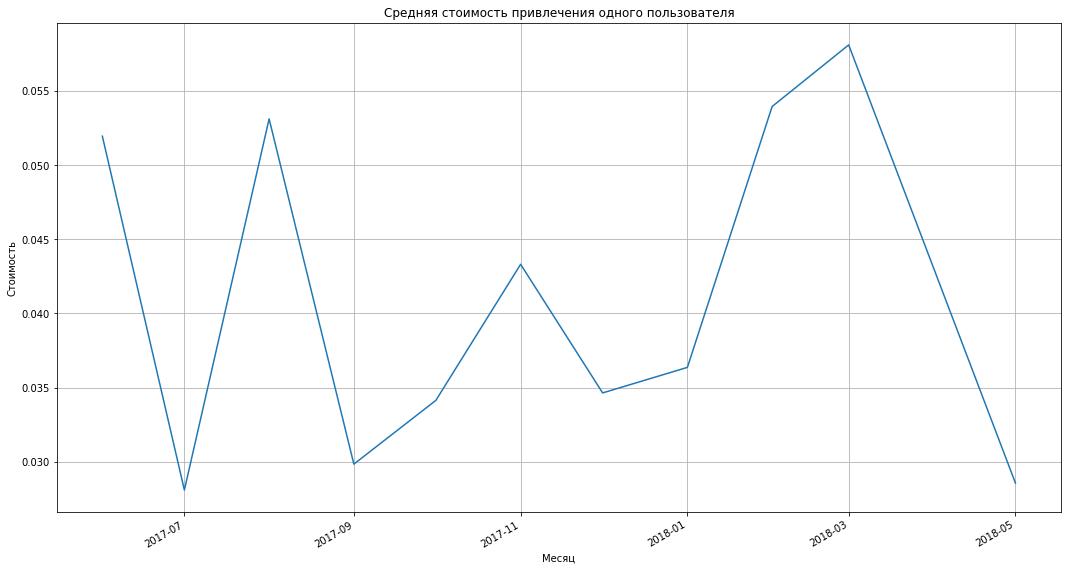

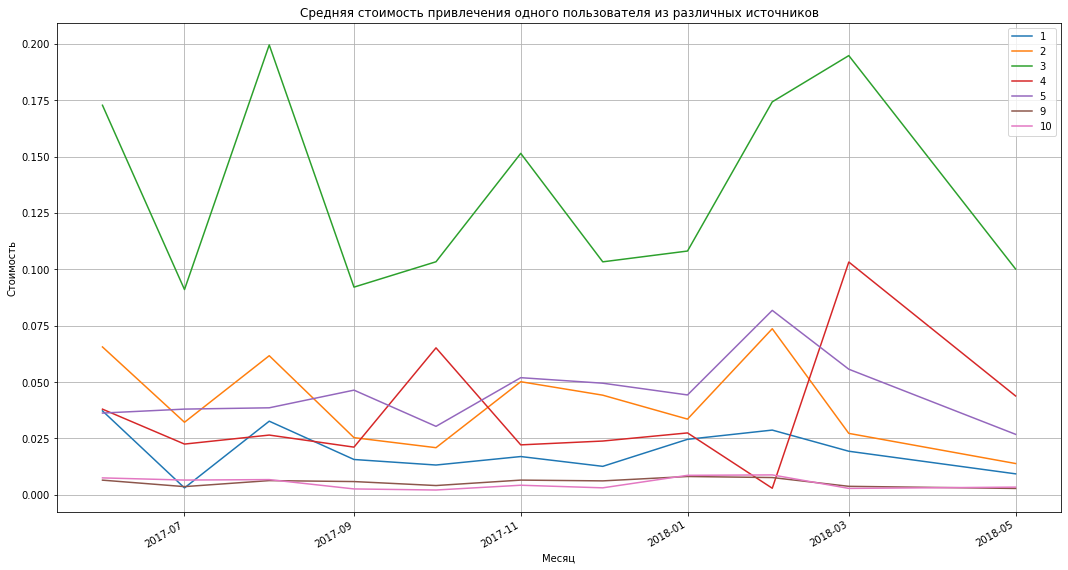

In [220]:
result_cac = pd.DataFrame()
for source_id in [1,2,3,4,5,9,10]:
    
    #Выделим необходимые данные о заказах и расходах
    orders_cac = orders.copy()
    costs_cac = costs[costs['source_id'] == source_id]
    # Получим месяц первой покупки каждого покупателя
    first_order_cac = orders_cac.groupby('uid').agg({'purchase_month':'min'}).reset_index()
    first_order_cac.columns = ['uid', 'first_order_month']
    # Посчитаем количесство новых покупателей за каждй месяц
    cac_cohort_sizes = first_order_cac.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
    cac_cohort_sizes.columns = ['first_order_month', 'n_buyers']
    # Добавим месяц первой покупки каждого покупателя в таблицу с заказами
    orders_cac_new = pd.merge(orders_cac,first_order_cac, on='uid')
    #Сгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим выручку
    cac_cohorts = orders_cac_new.groupby(['first_order_month','purchase_month']).agg({'revenue': 'sum'}).reset_index()
    cac_cohorts
    # Добавим в таблицу cac_cohorts данные о том, сколько людей первый раз совершили покупку в каждый месяц
    cac_report = pd.merge(cac_cohort_sizes, cac_cohorts, on = 'first_order_month')
    # Расчет LTV
    # Маржинальность все также равна единице
    # Найдём валовую прибыль 
    cac_report['gp'] = cac_report['revenue'] * margin_rate
    # Возраст когорты
    cac_report['age'] = (cac_report['purchase_month'] - cac_report['first_order_month']) / np.timedelta64(1, 'M')
    cac_report['age'] = cac_report['age'].round().astype('int')
    # Найдём LTV
    cac_report['LTV'] = cac_report['gp'] / cac_report['n_buyers']
    # Найдём суммареые расходы за каждый месяц
    cac_monthly_costs = costs_cac.groupby('dt').sum()
    # Добавим данные о расходах в отчет
    cac_report_new = pd.merge(cac_report, cac_monthly_costs, left_on = 'first_order_month', right_on = 'dt')
    # Посчитаем CAC
    cac_report_new['cac'] = cac_report_new['costs'] / cac_report_new['n_buyers']
    # Запись в новый датафрейм для вывода из цикла и получения общего графика
    result_cac[source_id] = cac_report_new.groupby('first_order_month')['cac'].mean()
    print('Средняя стоимость привлечения одного пользователя из источника',source_id,'равна:', round(result_cac[source_id].mean(), 3))

# График распределения CAC по времени    
result_cac.mean(axis = 1).plot(figsize = (18,10), grid = True)
plt.title('Средняя стоимость привлечения одного пользователя')
plt.xlabel('Месяц')
plt.ylabel('Стоимость');
plt.show()
# График распределения CAC по времени и источникам
result_cac.plot(figsize = (18,10), grid = True)
plt.title('Средняя стоимость привлечения одного пользователя из различных источников')
plt.xlabel('Месяц')
plt.ylabel('Стоимость');
plt.show()

Самыми дешевыми источниками привлечения новых пользователей являются источники 9 и 10. Самым дорогим третий.

Также были получены значения средних стоимостей привлечения пользователя из каждого источника.

По всей видимости на стоимость привлечения пользователя через источник напрямую влияет сумма затрат направляемая на этот источник. Об этом нам говорит схожесть последнего графика с графиком затрат на маркетинг по различным источникам. Положения различных источников на них совпадают.

### **<font color="Blue">Комментарии к исправлению</font>**
Я не смог добиться разделения CAC по источникам из своего полученного отчета **_report_new_**. Из-за некорректной группировки графики CAC по различным источникам получались одинаковыми. Поэтому я решил пойти в лоб и написал цикл для каждого источника, который просчитаывает весь расчет до CAC и выводит график. Мне не нравится текущее решение из-за массивности кода. 

### На сколько окупились расходы? (ROI)

**ROI** (от англ. _Return On Investment_ ) - показатель рентабельности вложений или ещё его называют коэффициентом возврата инвестиций. В нашем проекте все инветиции приходили с рекламных источников, поэтому логично назвать этот показатель ROMI (от англ. _Return On Marketing Investment_ ).

Он уже был расчитан чуть выше в коде. Поэтому можем сразу анализировать реезультаты.

Чтобы посчитать накопительный ROMI, вызовем метод cumsum(). Он последовательно складывает элементы множества. Его также представим в иде сводной таблицы по когортам

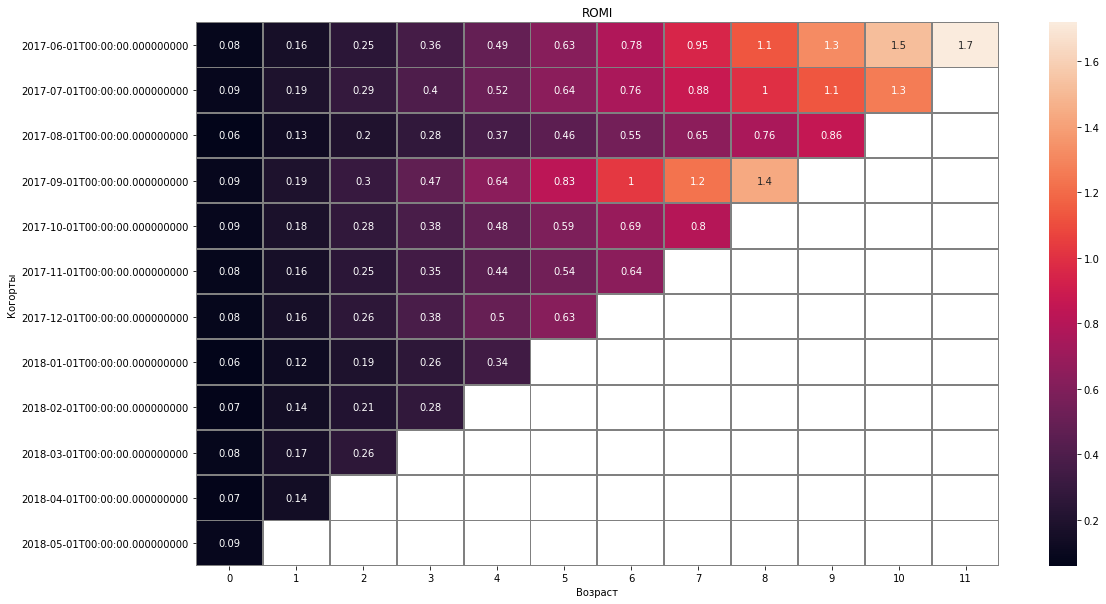

Средний ROMI пользователя за 6 месяцев после первой покупки: 0.6157774206890225


In [221]:
# Формирование сводной таблицы
output = report_new.pivot_table(
        index='first_order', 
        columns='age', 
        values='romi', 
        aggfunc='mean').cumsum(axis=1)
# Создание хитмапа
plt.figure(figsize = (18,10))
sns.heatmap(output.cumsum(axis=1).round(2), annot=True, linewidths=1, linecolor='gray');
plt.title('ROMI')
plt.xlabel('Возраст')
plt.ylabel('Когорты');
plt.show()
print('Средний ROMI пользователя за 6 месяцев после первой покупки:',output.cumsum(axis=1).mean(axis=0)[5])

На тепловой карте выидим, что лучшими когортами по ROI являются первая и четвертая. Это радует, так как похожая картина была получена при расчете пожизненной ценности клинета ранее. Значит скорее всего расчитанный показатель найден верно.

Теперь посмотрим на распределение среднего ROMI по источникам. Сперва представим их изменение по времени на одном графике, а далее постороим хитмапы по каждому из них.

Средний ROMI пользователя источника 1  за 6 месяцев после первой покупки: 0.581714099302011


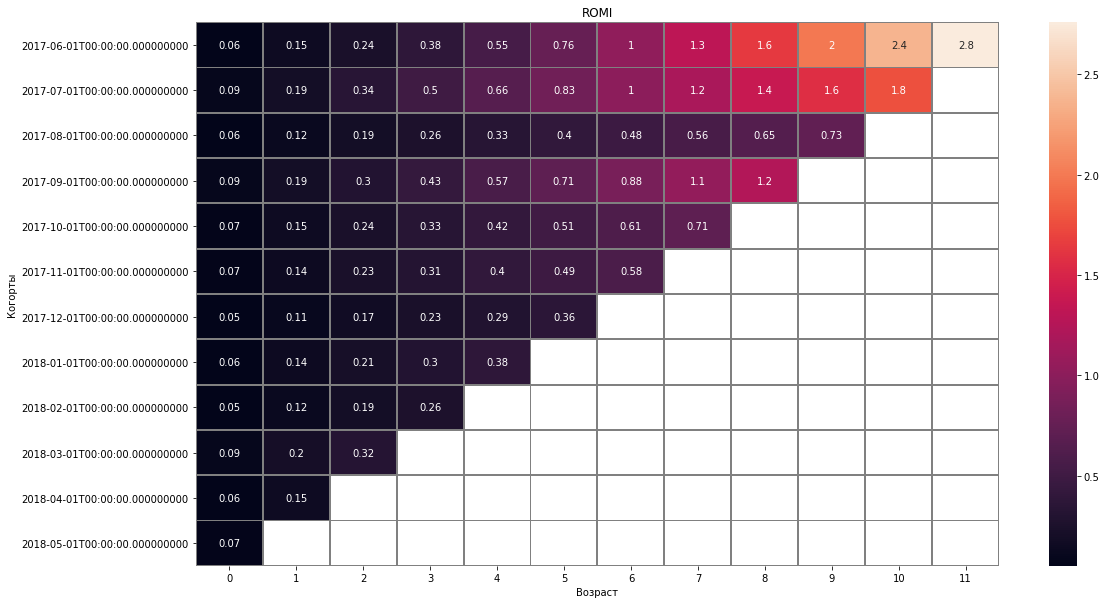

Средний ROMI пользователя источника 2  за 6 месяцев после первой покупки: 1.075607495869839


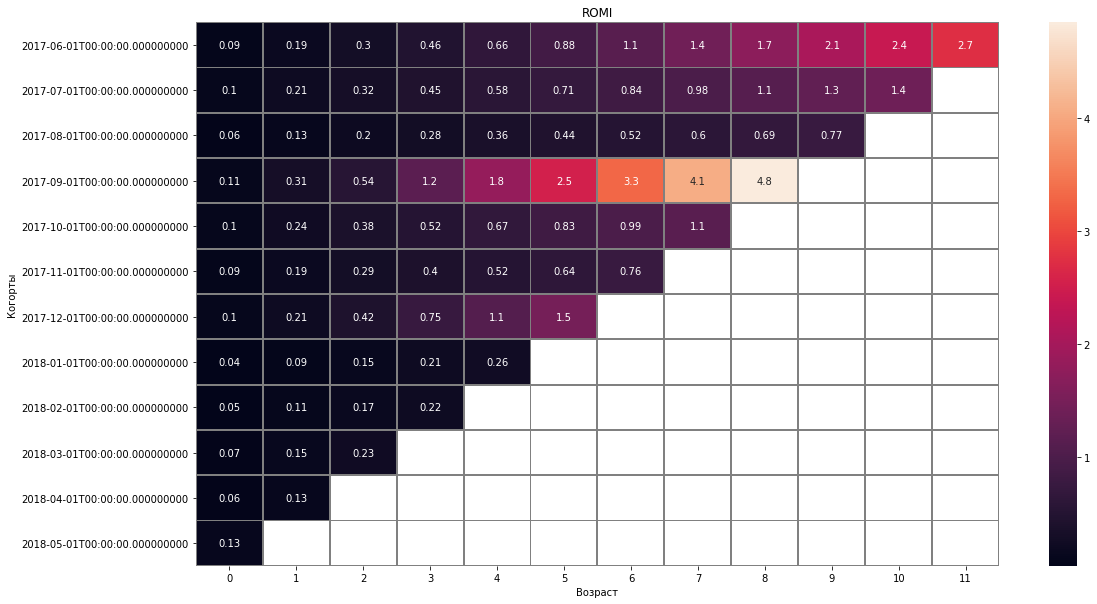

Средний ROMI пользователя источника 3  за 6 месяцев после первой покупки: 0.8115865991393889


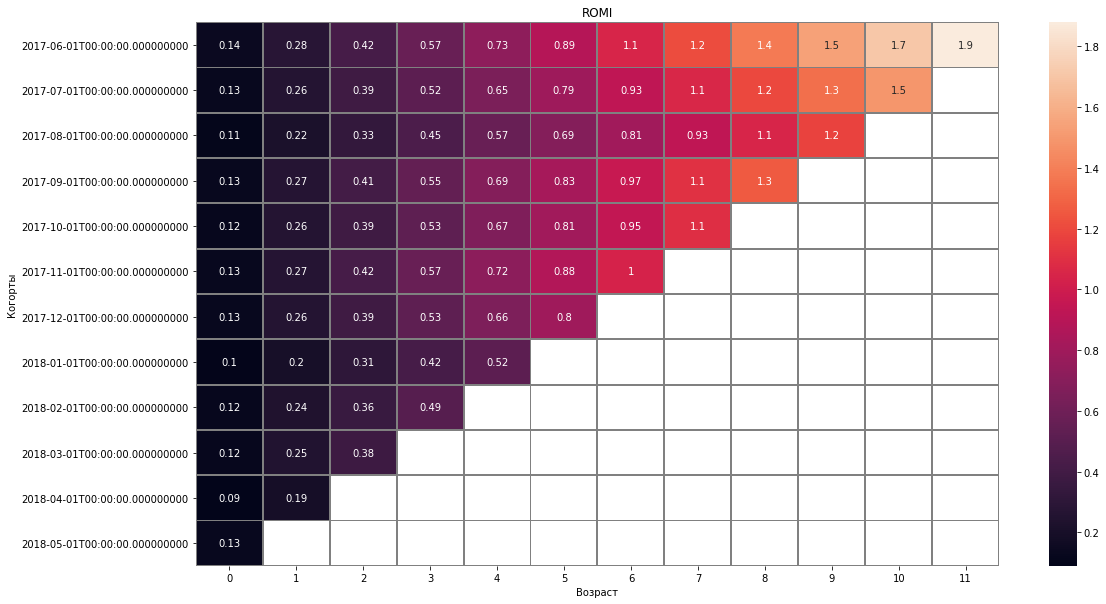

Средний ROMI пользователя источника 4  за 6 месяцев после первой покупки: 0.8830639866124901


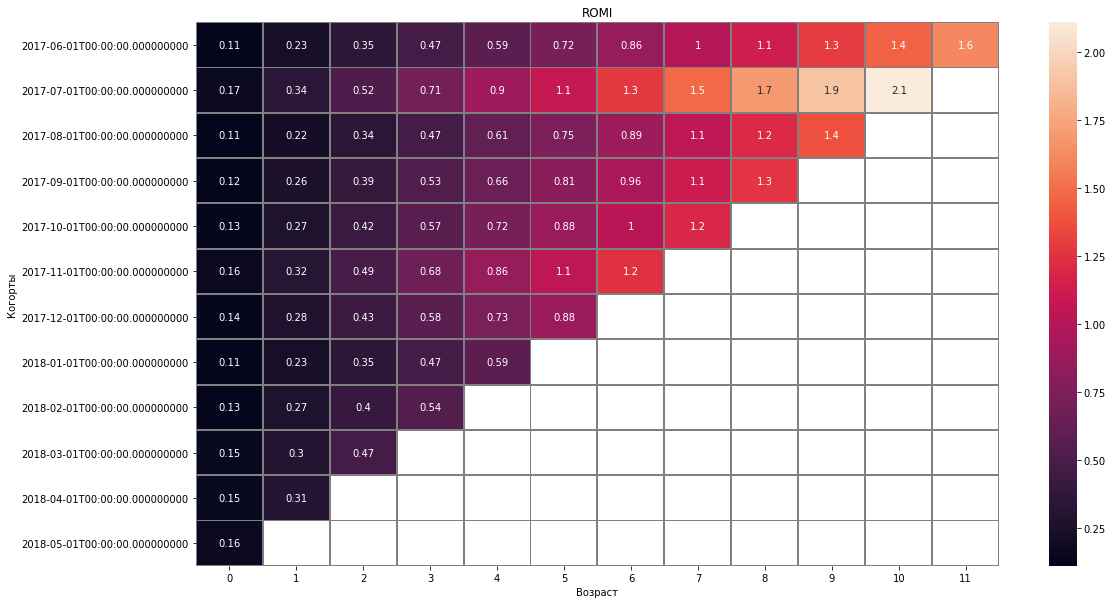

Средний ROMI пользователя источника 5  за 6 месяцев после первой покупки: 0.758371753413121


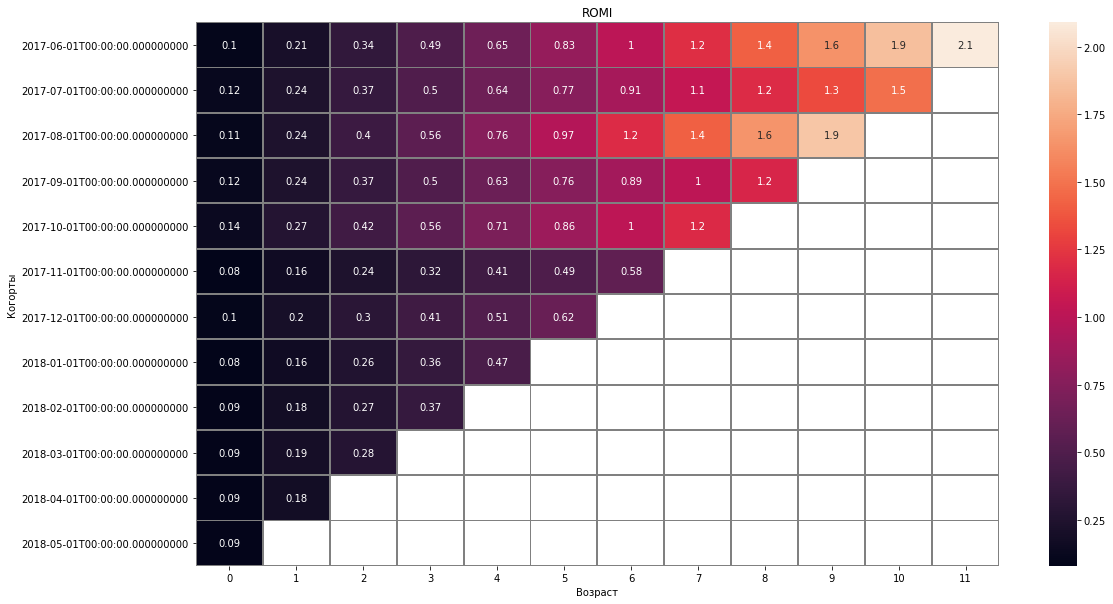

Средний ROMI пользователя источника 9  за 6 месяцев после первой покупки: 0.14963221065089002


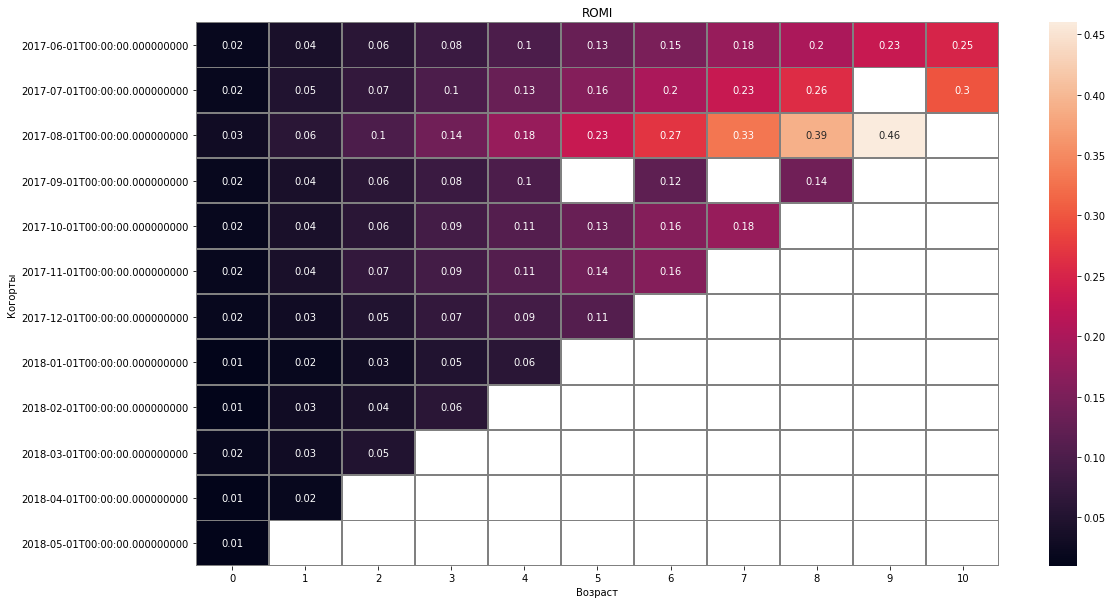

Средний ROMI пользователя источника 10  за 6 месяцев после первой покупки: 0.04895656166400983


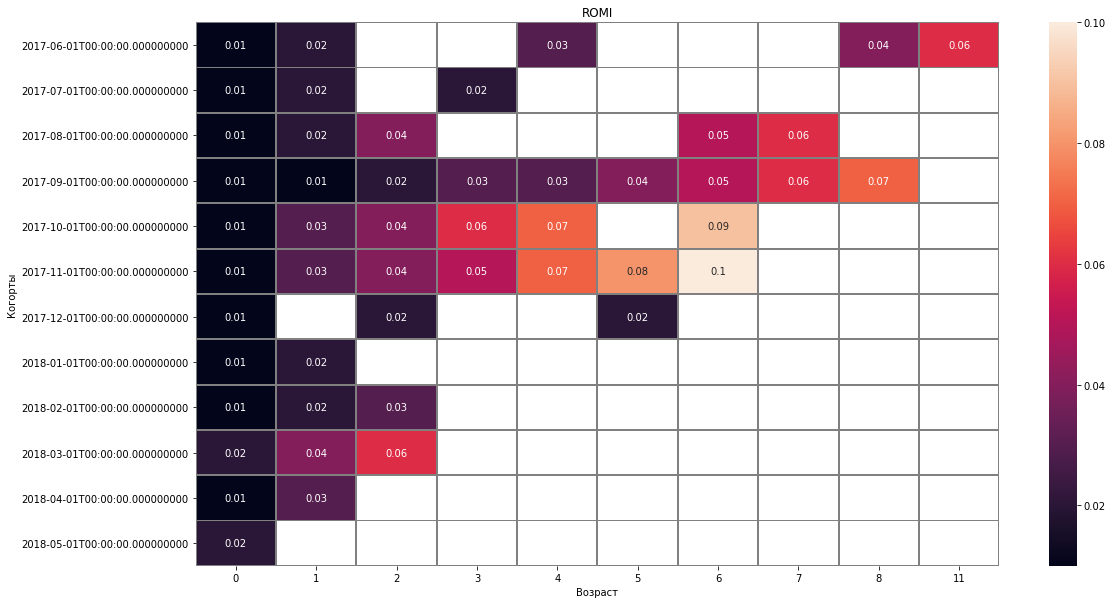

In [222]:
# Пустой датафрейм для вывода результатов из цикла
result_romi = pd.DataFrame()
for source_id in [1,2,3,4,5,9,10]:
    # Создание среза
    source_report_new = report_new[report_new['source_id'] == source_id]
    # Формирование сводной таблицы
    output = source_report_new.pivot_table(
            index='first_order', 
            columns='age', 
            values='romi', 
            aggfunc='mean').cumsum(axis=1)
    # Создание хитмапа
    plt.figure(figsize = (18,10))
    sns.heatmap(output.cumsum(axis=1).round(2), annot=True, linewidths=1, linecolor='gray');
    plt.title('ROMI')
    plt.xlabel('Возраст')
    plt.ylabel('Когорты');
    print('Средний ROMI пользователя источника', source_id ,' за 6 месяцев после первой покупки:',output.cumsum(axis=1).mean(axis=0)[5])
    plt.show()
    # Запись в датафрейм среднего занчения ROMI по каждой возрастной группе
    result_romi[source_id] = output.cumsum(axis = 1).mean(axis = 0)

Источник 2 демонстрирует самое высокое знычение среднего ROMI. Самые низкие значения соответствуют источникам 9 и 10.

Источник 2 не смотря на свою общую высокую окупаемость показывает странные значения по совим когортам. Её 4 когорта по всей видимости состоит из ярых фанатов фильмов, так как они демонстрируют бешенный рост ROMI. Именно эта когорта вытягивает ROMI данного источника.

Остальные источники демонстрируют более размеренный рост ROMI без скачков отдельных когорт.

Хорошо, мы также нашли средние значения ROMI каждого источника. Стоит отметить, что у первого источника ROMI не совсем показателен, так как он брался средним за первые полгода, но если смотреть на его когорты, которые прожили дольше, то видим, что они демонстрируют больший рост ROMI, чем у остальных источников.

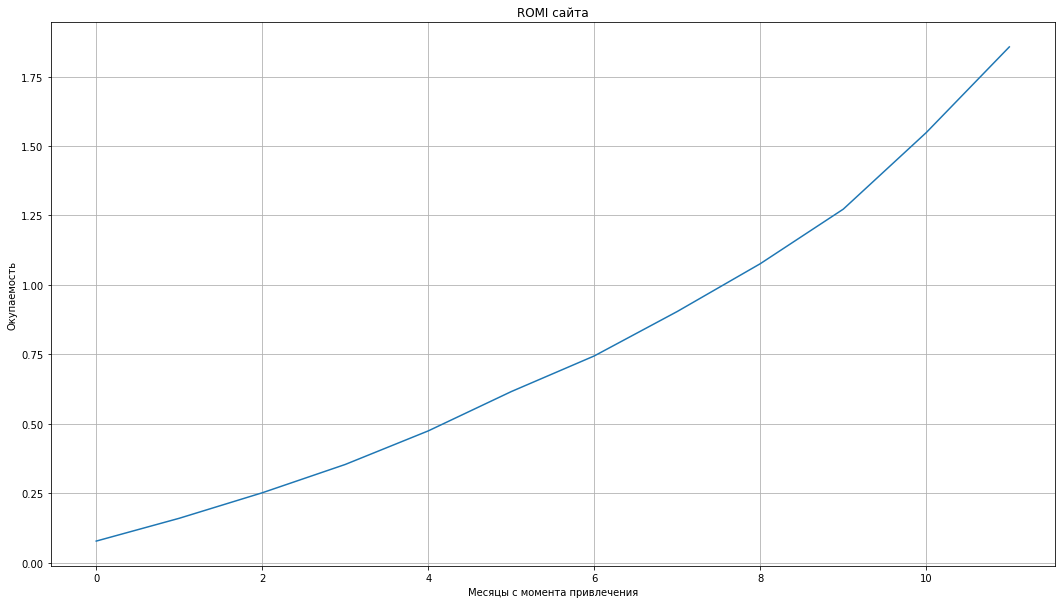

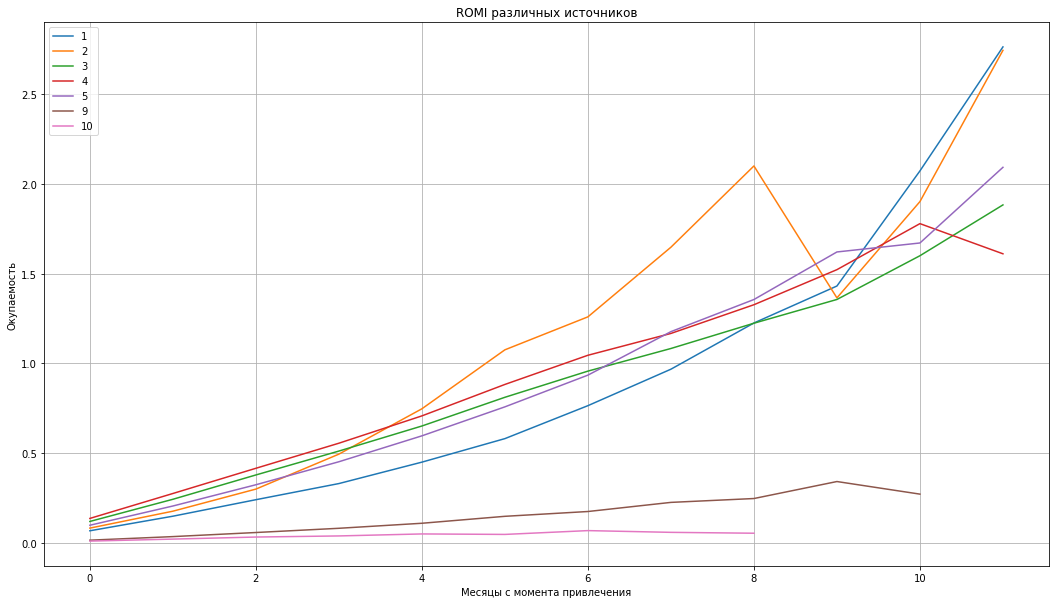

In [223]:
# График общего ROMI
result_romi.mean(axis = 1).plot(figsize = (18,10), grid = True)
plt.title('ROMI сайта')
plt.xlabel('Месяцы с момента привлечения')
plt.ylabel('Окупаемость')
plt.show()

# График ROMI по различным источникам
result_romi.plot(figsize = (18,10), grid = True)
plt.title('ROMI различных источников')
plt.xlabel('Месяцы с момента привлечения')
plt.ylabel('Окупаемость')
plt.show()

Из первого графика можно сделать вывод, что в целом, маркетинговые инвестиции окупаются за 7-8 месяцев.

Первые 5 источников имеют сравнительно допустимый средний ROMI. Они окупаются в среднем за полгода.

Самым лучшим в итоге оказался второй источник. За полгода он продемонстрировал самый высокий средний ROMI и самый высокий рост этого показателя. Первый же источник, который мы виделили при просмотре первого графика набирает хорошую скорость роста лишь под конец первого года, поэтому его средний ROMI оказался ниже, чем у второго источника, хоть он его и обгоняет под конец года.

У второго источника виден перелом ROMI  после 8го месяца. Это произошло из-за того, что его восьмимесячный отрыв ROMI от остальных обусловлен очень высокой окупаемостью в его четвертой когорте, которая прожила ровно 8 месяцев. Так как у данной когорты нет информации о девятом месяце, средний ROMI резко упал, так как окупаемость оставшихся трёх когорт ниже когорты 4.

Самыми плохими являются источники 9 и 10.

In [224]:
'''
Не смотри
'''

# # Создадим пустой датафрейм для сохранения в нём результатов каждого цикла
# result_romi = pd.DataFrame()
# for source_id in [1,2,3,4,5,9,10]:
    
#     #Выделим необходимые данные о заказах и расходах
#     orders_cac = orders.copy()
#     costs_cac = costs[costs['source_id'] == source_id]
#     # Получим месяц первой покупки каждого покупателя
#     first_order_cac = orders_cac.groupby('uid').agg({'purchase_month':'min'}).reset_index()
#     first_order_cac.columns = ['uid', 'first_order_month']
#     # Посчитаем количесство новых покупателей за каждй месяц
#     cac_cohort_sizes = first_order_cac.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
#     cac_cohort_sizes.columns = ['first_order_month', 'n_buyers']
#     # Добавим месяц первой покупки каждого покупателя в таблицу с заказами
#     orders_cac_new = pd.merge(orders_cac,first_order_cac, on='uid')
#     #Сгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим выручку
#     cac_cohorts = orders_cac_new.groupby(['first_order_month','purchase_month']).agg({'revenue': 'sum'}).reset_index()
#     cac_cohorts
#     # Добавим в таблицу cac_cohorts данные о том, сколько людей первый раз совершили покупку в каждый месяц
#     cac_report = pd.merge(cac_cohort_sizes, cac_cohorts, on = 'first_order_month')
#     # Расчет LTV
#     # Маржинальность все также равна единице
#     # Найдём валовую прибыль 
#     cac_report['gp'] = cac_report['revenue'] * margin_rate
#     # Возраст когорты
#     cac_report['age'] = (cac_report['purchase_month'] - cac_report['first_order_month']) / np.timedelta64(1, 'M')
#     cac_report['age'] = cac_report['age'].round().astype('int')
#     # Найдём LTV
#     cac_report['LTV'] = cac_report['gp'] / cac_report['n_buyers']
#     # Найдём суммареые расходы за каждый месяц
#     cac_monthly_costs = costs_cac.groupby('dt').sum()
#     # Добавим данные о расходах в отчет
#     cac_report_new = pd.merge(cac_report, cac_monthly_costs, left_on = 'first_order_month', right_on = 'dt')
#     cac_report_new['cac'] = cac_report_new['costs'] / cac_report_new['n_buyers']
#     cac_report_new['romi'] = cac_report['LTV'] / cac_report_new['cac']
#     result_romi[source_id] = cac_report_new.groupby('first_order_month')['romi'].mean()
#     romi_output = cac_report_new.pivot_table(
#         index = 'first_order_month', 
#         columns = 'age', 
#         values = 'romi', 
#         aggfunc = 'mean')
#     plt.figure(figsize = (18,10))
#     sns.heatmap(romi_output.cumsum(axis=1).round(), annot=True, linewidths=1, linecolor='gray');
#     plt.xlabel('Возраст когорты в месяцах')
#     plt.ylabel('Когорты');
#     print('Средний ROMI пользователя источника',source_id,' за 6 месяцев после первой покупки:',romi_output.cumsum(axis=1).mean(axis=0)[5])
#     plt.show()
    
# # result_cac.mean(axis = 1).plot(figsize = (18,10), grid = True)
# # plt.title('Средняя стоимость привлечения одного пользователя')
# # plt.xlabel('Месяц')
# # plt.ylabel('Стоимость');
# # plt.show()
# # result_cac.plot(figsize = (18,10), grid = True)
# # plt.title('Средняя стоимость привлечения одного пользователя из различных источников')
# # plt.xlabel('Месяц')
# # plt.ylabel('Стоимость');
# # plt.show()
    
# # Вывод графика    
# # result_romi.plot(figsize = (18,10), grid = True, xlim = (0,12))
# # plt.title('ROMI различных источников')
# # plt.xlabel('Месяцы с момента привлечения')
# # plt.ylabel('Средний ROMI');

'\nНе смотри\n'

In [225]:
# plt.figure(figsize = (18,10))
# sns.heatmap(
#     (report_new
#      .pivot_table(index = 'source_id', values = 'romi', columns = 'age', aggfunc = 'mean')
#      .cumsum(axis=1)
#      .round(2)
#     ), annot=True, linewidths=1, linecolor='gray')
# plt.title('ROMI')
# plt.xlabel('Месяцы с момента привлечения')
# plt.ylabel('Стоимость');

### Вывод

В данном пункте были расчитаны следующие маркетинговые показатели: были получены сведения о затратах, о стоимости привлечения покупателей и об окупаемости расчходов. Были тщательно разобраны рекламные источники, по каждому из них была найдены требуемая информация.

По следующим подпунктам были получены выводы:
- **Сколько денег потратили?** Были получены распределения количества денег направленных на рекламные источники на протяжении периода. Были рассмотрены затраты на каждый источник.
- **Сколько стоило привлечение одного покупателя из каждого источника?**  Были расчитаны значения средней стоимости привлечения одного пользователя(CAC) из разных источников. 
- **На сколько окупились расходы? (ROI)** Был рассчитан ROMI и получен график изменения ROMI по времени по различным источникам. Также были выделены источники с самыми высокими  и низкими значениями среднего ROMI.

## Шаг 3. Вывод: рекомендации маркетологам, куда и сколько им стоит вкладывать денег.

На основании полученных метрик я дам маркетологам следующие рекомендации по выбору платформы и источника рекламы 

### Платформа.
На выбор дано всего две платформы: ПК и смартфон (указанные в датасетах как desktop и touch соответственно).

- По рассчитанным данным пользовательской активности видим, что среднее количество пользователей и количество сесиий с компьютеров более чем в 2 раза превышает соответствующие количества на смартфонах.

- Типичная длительность сессий одинакова для обеих платформ и составляет 60 секунд.

- Среднее количество вернувшихся после первого визита пользователей также превышает на платформе ПК.

- Средний чек платформы ПК равен 4,98 ден.ед., что больше среднего чека на смартфонах на 0,66 ден.ед.

- Средняя пожизненная ценность(LTV) за 6 месяцев клиентов ПК состаляет 8,43 ден.ед., что больше аналогичного показателя на смартфонах на 2,42 ден. ед.

На основании выше приведенного сравнения можно однозначно сказать, что самым **лучшим вариантом для вложения денег является платформа ПК(desktop)**.

### Рекламный источник
Здесь выбор побольше. Даны: источники 1, 2, 3, 4, 5, 9 и 10. В таблице _orders_ содержалась также информация об источниках 6 и 7, но у них отсутствовала какая-либо информация о затратах на них, поэтому данные источники даже не рассматриваются.

Кратко изложу выводы из маркетинговых метрик:

- **LTV**. Источником с самыми ценными клиентами является источник 2. Средняя LTV за полгода пользователей пришедших с данного источника равна 19,63 ден.ед. Вторым по данному показателю является источник 1 с 10,69 ден. ед. Самая низкая LTV у источника 10 равная 3,75 ден.ед.

- **Затраты**. Самыми дешёвыми по затратам на маркетинг являются источники 9, 10 и 1. Самым дорогим является источник 3. Остальные посередине.

- **CAC**. Средняя стоимость привлечения одного пользователя. Самые "дешевые" пользователи у источников 9 и 10 - 0,005 д. и 0,006 д. соответственно. И самые дорогие у источника 3 - 0,136 ден.ед.

- **ROMI**. Самым окупаемым источником является источник 2. За полгода он окупился на 107,5%. Самыми неокупаемыми являются источники 9 и 10.

Из выводов становится понятно, что **самым правильным вариантом для вложения денег является источник 2**. Хоть и стоимость привлечения нового пользователя(САС) у него не самая низкая, но это перекрывается самой высокой LTV среди источников и в итоге за полгода его окупаемость составляет 107,5%! Этот источник быстрее остальных вернёт вложенные деньги.

В качестве альтернативы могу порекомендовать источник 1. По данным за полгода он показывает сравнительно не самые лучшие показатели по окупаемости, но рост LTV его пользователей значительно выше, чем у остальных, а значит что скорость его окупаемости будет расти быстрее, чем у остальных. Также, стоимость привлечения пользователей через данный источник сравнительно низкая, что позволит привести больше покупателей.